In [2]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
#import alipy

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
quas = os.listdir('/../home/lynge/MasterP/K/')
quas = [os.path.join('/../home/lynge/MasterP/K',f) \
        for f in os.listdir('/../home/lynge/MasterP/K/')]
#print quas
#quasar = pyfits.getdata(quas[0])
header = pyfits.getheader(quas[0])
#w = WCS('/../home/lynge/MasterP/NGC3783K/NGC3783_3_10_K.fits')

#print header

c = SkyCoord('11h39m01.68s', '-37d44m18.2s')


qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333
gal_RA_WORLD = 174.69151250 + 0.6/3600.# Galaxy
gal_DEC_WORLD = -37.71181944 + 0.4/3600

sky_RA_WORLD = 174.75445032458904 #Random patch of sky
sky_DEC_WORLD = -37.77465736280882

'''11 38 55.30733 -37 41 33.1000 LEDA 619241'''

print 174.69151250 + 0.6/3600., -37.71181944 + 0.4/3600


star = fits.open('NGC3783K/rdls.fits')
#print fits.getheader('NGC3783K/rdls.fits')

image = fits.open('NGC3783K/rdls.fits')
image_data = fits.getdata('NGC3783K/rdls.fits')

#print image_data

#plt.figure()
#plt.imshow(pyfits.getdata(quas[0]))
#plt.colorbar()
#plt.show()

#aperture = 0.006

#plt.figure()
#plt.imshow(quasar)
#plt.show()

174.691679167 -37.7117083289


INFO: Auto-setting vmin to -3.376e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.377e+02 [aplpy.core]


"\nap = apl.FITSFigure(image_data,figsize=(5,5))\nap.recenter(300,300,150)\nap.show_colorscale(aspect='auto')\nap.add_grid()\n#ap.show_circles(174.774,-37.755,0.02)"

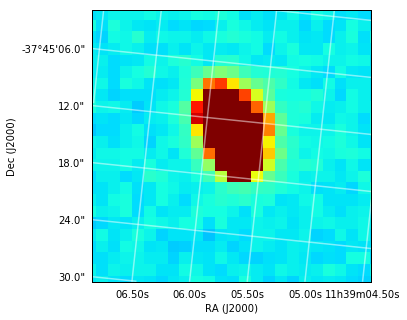

In [13]:
image = fits.open(quas[3])[0]
image_data = fits.getdata(quas[0])

ap = apl.FITSFigure(image,figsize=(5,5))
ap.recenter(174.774,-37.7540888889,0.004)
ap.show_colorscale(aspect='auto')
ap.show_circles(174.774,-37.755,0.003)
ap.add_grid()

'''
ap = apl.FITSFigure(image_data,figsize=(5,5))
ap.recenter(300,300,150)
ap.show_colorscale(aspect='auto')
ap.add_grid()
#ap.show_circles(174.774,-37.755,0.02)'''

In [4]:
w = WCS(quas[0])
print w.all_pix2world(250,250,0)

[array(174.75445032458904), array(-37.77465736280882)]


In [5]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [6]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later flux determination, \
    it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

'''The models used for PSF fitting'''
Airy = models.AiryDisk2D()
Gauss2D = models.Gaussian2D()
fit = fitting.LevMarLSQFitter()
or_fit = fitting.FittingWithOutlierRemoval(fit,sigma_clip,niter=3,sigma=3.0)

In [7]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    try:
        mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
        AGNdata[mask] = float(0)
        mask = AGNdata == 0.
        rows = np.flatnonzero((~mask).sum(axis=1))
        cols = np.flatnonzero((~mask).sum(axis=0))
        AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
        #print apparature/float(pixspa)
    except:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata/float(exptime), x1, y1


In [8]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me or by the \
    SExtractor program respectively'''
    comp = qua/sta
    return comp

In [9]:
def SXtable(quas,aperture,s):
    header = pyfits.getheader(quas[s])
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":5, 'DETECT_MINAREA':5, 'DETECT_MAXAREA':100, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas[s])
    return out

In [10]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    output = np.zeros(((len(quas))),dtype=np.dtype([('flux_main',float),('time',float),('err',float),\
                                                    ('err_bar',float), ('posx',float),('posy',float),\
                                                    ('posx_err',float),('posy_err',float),('Ellipticity',float)]))
    headerlist = []
    for i in range(len(quas)):
        out = SXtable(quas,aperture,i)
        RAmain = WCS(quas[i]).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
        DECmain = WCS(quas[i]).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
        #RAsec = WCS(quas[i]).all_world2pix(sec_RA_WORLD,sec_DEC_WORLD,1)[0]
        #DECsec = WCS(quas[i]).all_world2pix(sec_RA_WORLD,sec_DEC_WORLD,1)[1]
        header = pyfits.getheader(quas[i])
        #mask = (out['table']['XMODEL_IMAGE'] < RAmain - 2) & (out['table']['XMODEL_IMAGE'] > RAmain + 2)
        output['flux_main'][i] = np.nan
        output['time'][i] = header['MJD-OBS']
        output['err'][i] = np.nan
        output['err_bar'][i] = np.nan
        output['posx'][i] = np.nan
        output['posx_err'][i] = np.nan
        output['posy'][i] = np.nan
        output['posy_err'][i] = np.nan
        output['Ellipticity'][i] = np.nan
        headerlist.append(header)
        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 1. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 1. and \
            DECmain - 1. < out['table']['YMODEL_IMAGE'][j] < DECmain + 1.:
                output['flux_main'][i] = out['table']['FLUX_APER'][j]
                output['err'][i] = 3600*np.sqrt((out['table']['XMODEL_WORLD'][j] - main_RA_WORLD)**2 \
                                        + (out['table']['YMODEL_WORLD'][j] - main_DEC_WORLD)**2)
                output['err_bar'][i] = np.sqrt(out['table']['X2MODEL_WORLD'][j]**2 \
                                       + out['table']['Y2MODEL_WORLD'][j]**2)
                output['posx'][i] = out['table']['XMODEL_WORLD'][j]
                output['posx_err'][i] = out['table']['X2MODEL_WORLD'][j]
                output['posy'][i] = out['table']['YMODEL_WORLD'][j]
                output['posy_err'][i] = out['table']['Y2MODEL_WORLD'][j]
                output['Ellipticity'][i] = out['table']['ELLIPTICITY'][j]
    print 'Done'
    return output, headerlist


In [11]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1/10.
    data2_2 = data2/10.
    return SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

Filter transmission and quantum efficincy is not known.

The flux is determined in the individual stellar objects by the use of SExtractor. It also adds the header to the general array for use later.

  - I should aim to speed the process up, eliminate for loops
  - Improve upon the arrays. 

aperture1 = 0.001
aperture2 = 0.002

quasar_1 = dataset2 = flux(quas,aperture1,qua1_RA_WORLD,qua1_DEC_WORLD,sta2_RA_WORLD,sta2_DEC_WORLD)
star_1 = dataset4 = flux(quas,aperture1,qua1_RA_WORLD,qua1_DEC_WORLD,sta1_RA_WORLD,sta1_DEC_WORLD)
quasar_2 = dataset2 = flux(quas,aperture2,qua1_RA_WORLD,qua1_DEC_WORLD,sta2_RA_WORLD,sta2_DEC_WORLD)
star_2 = dataset4 = flux(quas,aperture2,qua1_RA_WORLD,qua1_DEC_WORLD,sta1_RA_WORLD,sta1_DEC_WORLD)

source = quasar_1['flux_main']/(aperture1/)

SNR_array = np.zeros((8),dtype=np.dtype([('aperture',float),('qua',float),('sta1',float),('sta2',float)]))    
SNR_array['aperture'] = aperture1
SNR_array['qua'] = SNR(10,)

In [12]:
aperture = 0.001
aperture1 = 0.002
dataqua, headerqua = flux(quas,aperture,qua1_RA_WORLD,qua1_DEC_WORLD)
datasta1, headersta1 = flux(quas,aperture,sta1_RA_WORLD,sta1_DEC_WORLD)
datasta2, headersta2 = flux(quas,aperture,sta2_RA_WORLD,sta2_DEC_WORLD)
datasta3, headersta3 = flux(quas,aperture,sta3_RA_WORLD,sta3_DEC_WORLD)
datagal, headergal = flux(quas,aperture,gal_RA_WORLD,gal_DEC_WORLD)

dataqua_1, headerqua_1 = flux(quas,aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)
datasta1_1, headersta1_1 = flux(quas,aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)
datasta2_1, headersta2_1 = flux(quas,aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)
datasta3_1, headersta3_1 = flux(quas,aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)
datagal_1, headergal_1 = flux(quas,aperture1,gal_RA_WORLD,gal_DEC_WORLD)


No handlers could be found for logger "sewpy.sewpy"


Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [13]:
print datagal['flux_main']

[      nan  2851.263       nan  2536.877  2145.871       nan  2778.957
  2567.069  2973.492  3306.145       nan  1766.711       nan       nan
       nan  2097.888       nan       nan  2339.781  1801.95   2330.905
  3008.322  2567.755       nan  2876.073  3443.933       nan       nan
  2610.014  2055.062  3018.469  3130.156       nan       nan]


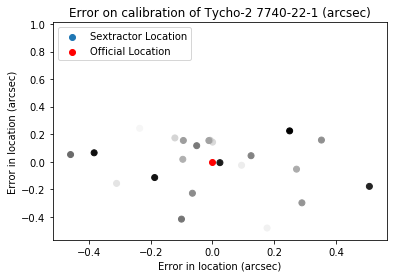

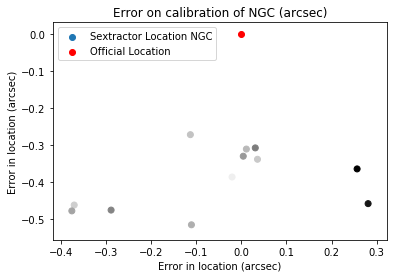

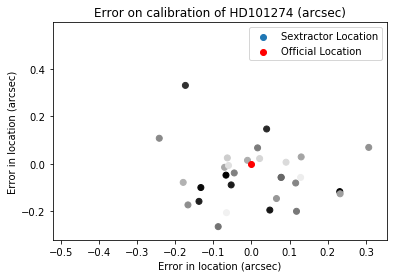

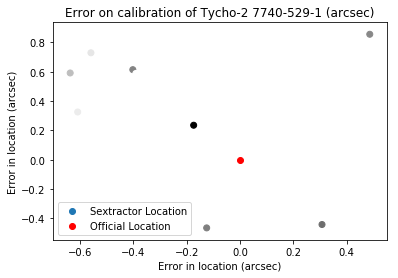

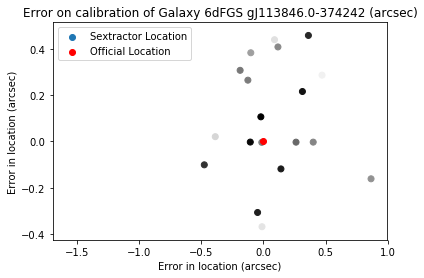

In [14]:
refx = sta2_RA_WORLD
refy = sta2_DEC_WORLD

plt.figure()
plt.scatter((datasta2['posx']-refx)*3600,(datasta2['posy']-refy)*3600,\
            c=datasta2['time'],cmap='gray',label='Sextractor Location') 
plt.scatter((0)*3600,(0)*3600,color='r',label='Official Location')
#plt.colorbar(gray)
#plt.ylim([-37.7389,-37.7383])
#plt.xlim([174.7570,174.75735])
plt.title('Error on calibration of Tycho-2 7740-22-1 (arcsec)')
plt.xlabel('Error in location (arcsec)')
plt.ylabel('Error in location (arcsec)')
plt.legend()
plt.show()

refx = qua1_RA_WORLD
refy = qua1_DEC_WORLD

plt.figure()
plt.scatter((dataqua['posx']-refx)*3600,(dataqua['posy']-refy)*3600,\
            c=dataqua['time'],cmap='gray',label='Sextractor Location NGC') 
plt.scatter((0)*3600,(0)*3600,color='r',label='Official Location')
#plt.colorbar(gray)
#plt.ylim([-37.7389,-37.7383])
#plt.xlim([174.7570,174.75735])
plt.title('Error on calibration of NGC (arcsec)')
plt.xlabel('Error in location (arcsec)')
plt.ylabel('Error in location (arcsec)')
plt.legend()
plt.show()

refx = sta1_RA_WORLD
refy = sta1_DEC_WORLD

plt.figure()
plt.scatter((datasta1['posx']-refx)*3600,(datasta1['posy']-refy)*3600,\
            c=datasta1['time'],cmap='gray',label='Sextractor Location') 
plt.scatter((0)*3600,(0)*3600,color='r',label='Official Location')
#plt.colorbar(gray)
#plt.ylim([-37.7389,-37.7383])
#plt.xlim([174.7570,174.75735])
plt.title('Error on calibration of HD101274 (arcsec)')
plt.xlabel('Error in location (arcsec)')
plt.ylabel('Error in location (arcsec)')
plt.legend()
plt.show()

refx = sta3_RA_WORLD
refy = sta3_DEC_WORLD

plt.figure()
plt.scatter((datasta3['posx']-refx)*3600,(datasta3['posy']-refy)*3600,\
            c=datasta3['time'],cmap='gray',label='Sextractor Location') 
plt.scatter((0)*3600,(0)*3600,color='r',label='Official Location')
#plt.colorbar(gray)
#plt.ylim([-37.7389,-37.7383])
#plt.xlim([174.7570,174.75735])
plt.title('Error on calibration of Tycho-2 7740-529-1 (arcsec)')
plt.xlabel('Error in location (arcsec)')
plt.ylabel('Error in location (arcsec)')
plt.legend()
plt.show()

refx = gal_RA_WORLD
refy = gal_DEC_WORLD

plt.figure()
plt.scatter((datagal['posx']-refx)*3600,(datagal['posy']-refy)*3600,\
            c=datagal['time'],cmap='gray',label='Sextractor Location') 
plt.scatter((0)*3600,(0)*3600,color='r',label='Official Location')
#plt.colorbar(gray)
#plt.ylim([-37.7389,-37.7383])
#plt.xlim([174.7570,174.75735])
plt.title('Error on calibration of Galaxy 6dFGS gJ113846.0-374242 (arcsec)')
plt.xlabel('Error in location (arcsec)')
plt.ylabel('Error in location (arcsec)')
plt.legend()
plt.show()



It does appear as if the two identified stars is located with a slight bias in the RA. It further appears that the larger star (HD101274) is identified with a lesser degree of precision, as should probably be expected as the PSF (or other similar models) is less point like due to the extention of the star on the night sky. 

NGC 3783 is however located with a significant bias towards a lower DEC angle. It could be that the Seyfert-1 galaxy it is located in is at an inclination angle (i) towards the telescope, hence increasing the luminosity observed from the lowar part of the galaxy and hiding the stellar lominosity from the upper part. This combined with the non-point like behaviour of the PSF, due to the galactic background, could have shifted SExtractors model towards lower DEC angle. 

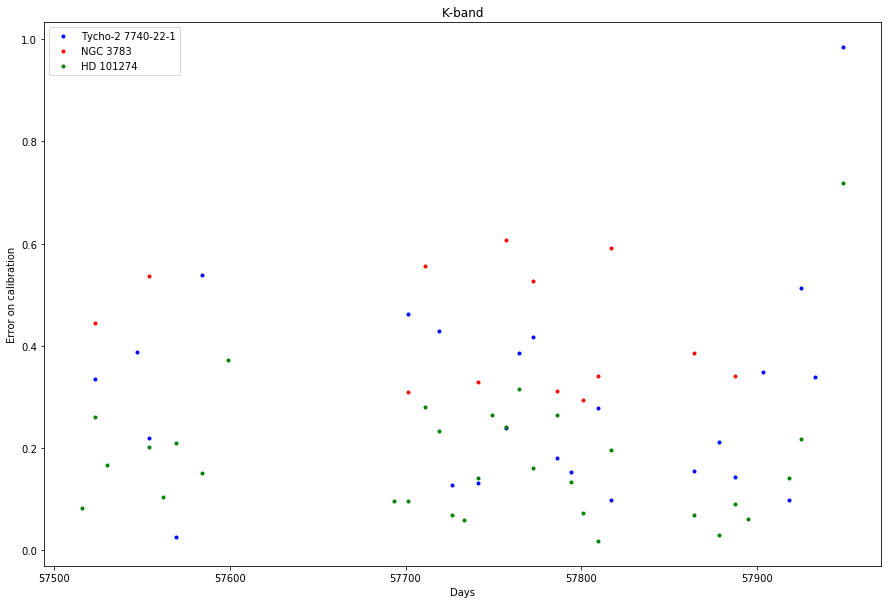

"\nplt.figure()\n#plt.scatter(time,err)\nplt.errorbar(np.trim_zeros(dataset2['time']),np.trim_zeros(dataset2['err']),fmt='.')\nplt.xlabel('Days')\nplt.ylabel('Error on calibration of NGC (K-band)')\n#plt.ylim([0,1.5])\nplt.title('NGC 3783')\nplt.show()\n\nplt.figure()\n#plt.scatter(time,err)\nplt.errorbar(np.trim_zeros(dataset3['time']),np.trim_zeros(dataset3['err']),fmt='.')\nplt.xlabel('Days')\nplt.ylabel('Error on calibration')\n#plt.ylim([0,1.5])\nplt.title('HD 101274 (K-band)')\nplt.show()\n"

In [15]:
#print quas

#print flux_qua
#print flux_sta
#print flux_comp

#print flux_sta
plt.figure(figsize=(15,10))
#plt.scatter(time,err)
plt.errorbar(datasta2['time'],datasta2['err'],label=('Tycho-2 7740-22-1'),color='b',fmt='.')
plt.errorbar(dataqua['time'],dataqua['err'],label=('NGC 3783'),color='r',fmt='.')
plt.errorbar(datasta1['time'],datasta1['err'],label=('HD 101274'),color='g',fmt='.')
plt.xlabel('Days')
plt.ylabel('Error on calibration')
plt.title('K-band')
#plt.ylim([0,1.5])
plt.legend()
plt.show()
'''
plt.figure()
#plt.scatter(time,err)
plt.errorbar(np.trim_zeros(dataset2['time']),np.trim_zeros(dataset2['err']),fmt='.')
plt.xlabel('Days')
plt.ylabel('Error on calibration of NGC (K-band)')
#plt.ylim([0,1.5])
plt.title('NGC 3783')
plt.show()

plt.figure()
#plt.scatter(time,err)
plt.errorbar(np.trim_zeros(dataset3['time']),np.trim_zeros(dataset3['err']),fmt='.')
plt.xlabel('Days')
plt.ylabel('Error on calibration')
#plt.ylim([0,1.5])
plt.title('HD 101274 (K-band)')
plt.show()
'''


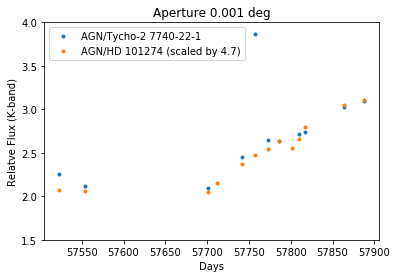

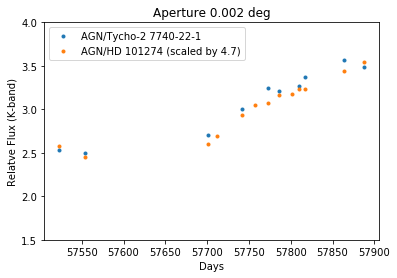

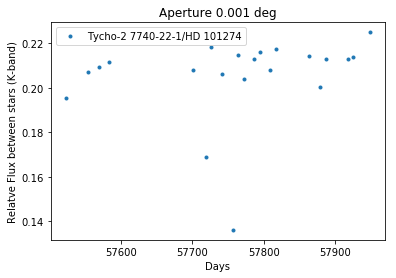

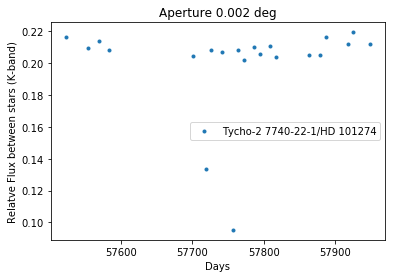

In [16]:
plt.figure()
#plt.scatter(time,err)
plt.errorbar(dataqua['time'],comp1(dataqua['flux_main'],datasta2['flux_main']),\
             fmt='.',label='AGN/Tycho-2 7740-22-1')
plt.errorbar(dataqua['time'],comp1(dataqua['flux_main'],datasta1['flux_main'])*4.7,\
             fmt='.',label='AGN/HD 101274 (scaled by 4.7)')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
#plt.ylim([0,1.5])
plt.ylim([1.5,4])
plt.legend()
plt.show()

plt.figure()
#plt.scatter(time,err)
plt.errorbar(dataqua_1['time'],comp1(dataqua_1['flux_main'],datasta2_1['flux_main']),\
             fmt='.',label='AGN/Tycho-2 7740-22-1')
plt.errorbar(dataqua_1['time'],comp1(dataqua_1['flux_main'],datasta1_1['flux_main'])*4.7,\
             fmt='.',label='AGN/HD 101274 (scaled by 4.7)')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.002 deg')
#plt.ylim([0,1.5])
plt.ylim([1.5,4])
plt.legend()
plt.show()


plt.figure()
#plt.scatter(time,err)
plt.errorbar(datasta1['time'],comp1(datasta2['flux_main'],datasta1['flux_main']),\
             fmt='.',label='Tycho-2 7740-22-1/HD 101274')
plt.xlabel('Days')
plt.ylabel('Relatve Flux between stars (K-band)')
plt.title('Aperture 0.001 deg')
#plt.ylim([0,1.5])
#plt.ylim([0,0.4])
plt.legend()
plt.show()

plt.figure()
#plt.scatter(time,err)
plt.errorbar(datasta1_1['time'],comp1(datasta2_1['flux_main'],datasta1_1['flux_main']),\
             fmt='.',label='Tycho-2 7740-22-1/HD 101274')
plt.xlabel('Days')
plt.ylabel('Relatve Flux between stars (K-band)')
plt.title('Aperture 0.002 deg')
#plt.ylim([0,1.5])
#plt.ylim([0,0.4])
plt.legend()
plt.show()


The observation shows that despite large variations in the stellar luminosity over time, these variations tend to follow each other, and as such one must conclude that the variations must likely is mostly due to athmopheric variations. It aditionally shows that the change in flux over time mostly are comparable. It appears on first glance that Aperture = 0.001 deg is too small a radius to use in the investigations ahead. 

aperture = 0.001
for i in range(10):
    aperture = aperture + 0.001
    #dataset = flux(quas,aperture,sta2_RA_WORLD,sta2_DEC_WORLD,qua1_RA_WORLD,qua1_DEC_WORLD)
    dataset2 = flux(quas,aperture,qua1_RA_WORLD,qua1_DEC_WORLD,sta2_RA_WORLD,sta2_DEC_WORLD)
    #dataset3 = flux(quas,aperture,sta1_RA_WORLD,sta1_DEC_WORLD,qua1_RA_WORLD,qua1_DEC_WORLD)
    dataset4 = flux(quas,aperture,qua1_RA_WORLD,qua1_DEC_WORLD,sta1_RA_WORLD,sta1_DEC_WORLD)
    dataset5 = flux(quas,aperture,sta2_RA_WORLD,sta2_DEC_WORLD,sta1_RA_WORLD,sta1_DEC_WORLD)
    print aperture


    plt.figure()
    #plt.scatter(time,err)
    plt.errorbar(np.trim_zeros(dataset2['time']),np.trim_zeros(dataset2['flux_comp']),fmt='.',label='Tycho-2 7740-22-1')
    plt.errorbar(np.trim_zeros(dataset4['time']),np.trim_zeros(dataset4['flux_comp']*4),fmt='.',label='HD 101274 (scaled by 4)')
    plt.xlabel('Days')
    plt.ylabel('Relatve Flux (K-band)')
    #plt.ylim([0,1.5])
    plt.ylim([0,7])
    plt.legend()
    plt.show()


    plt.figure()
    #plt.scatter(time,err)
    plt.errorbar(np.trim_zeros(dataset5['time']),np.trim_zeros(dataset5['flux_comp']),fmt='.',label='Tycho-2 7740-22-1/HD 101274')
    plt.xlabel('Days')
    plt.ylabel('Relatve Flux between stars (K-band)')
    #plt.ylim([0,1.5])
    plt.ylim([0,0.4])
    plt.legend()
    plt.show()

    


for i in range(len(quas)):
    image = fits.open(quas[i])
    image_data = fits.getdata(quas[i])

    ap = apl.FITSFigure(image,figsize=(5,5))
    #ap.recenter(c.ra.deg,c.dec.deg,0.0053391667)
    ap.show_colorscale(aspect='auto')
    ap.add_grid()
    #ap.show_circles(174.757 -37.7383888889,0.008)
    plt.show()


In [17]:
aperture1 = 0.001
aperture2 = 0.002
date = []
flucompsta1 = []
flucompsta2 = []
flucompsta3 = []
flucompsta4 = []
flucompsta5 = []
flucompsta6 = []
flucompsta7 = []
flucompsta1_1 = []
flucompsta2_1 = []
flucompsta3_1 = []
flucompsta4_1 = []
flucompsta5_1 = []
flucompsta6_1 = []
flucompsta7_1 = []
SNR1 = []
SNR2 = []
SNR3 = []
SNR4 = []
SNR5 = []
SNR1_1 = []
SNR2_1 = []
SNR3_1 = []
SNR4_1 = []
SNR5_1 = []
SNR_comp = []

for i in range(len(quas)):
    #print 'Frame nr. ', i
    header = pyfits.getheader(quas[i])
    a1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (qua1_RA_WORLD,qua1_DEC_WORLD),aperture1)[0]
    a2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta1_RA_WORLD,sta1_DEC_WORLD),aperture1)[0]
    a3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta2_RA_WORLD,sta2_DEC_WORLD),aperture1)[0]
    a4 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta3_RA_WORLD,sta3_DEC_WORLD),aperture1)[0]
    a5 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (gal_RA_WORLD,gal_DEC_WORLD),aperture1)[0]
    a1_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (qua1_RA_WORLD,qua1_DEC_WORLD),aperture2)[0]
    a2_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta1_RA_WORLD,sta1_DEC_WORLD),aperture2)[0]
    a3_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta2_RA_WORLD,sta2_DEC_WORLD),aperture2)[0]
    a4_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta3_RA_WORLD,sta3_DEC_WORLD),aperture2)[0]
    a5_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (gal_RA_WORLD,gal_DEC_WORLD),aperture2)[0]
    a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]
    date.append(header['MJD-OBS'])
    flucompsta1.append(comp1(np.sum(a1),np.sum(a2)))
    flucompsta2.append(comp1(np.sum(a1),np.sum(a3)))
    flucompsta3.append(comp1(np.sum(a3),np.sum(a2)))
    flucompsta4.append(comp1(np.sum(a1),np.sum(a4)))
    flucompsta5.append(comp1(np.sum(a1),np.sum(a5)))
    flucompsta6.append(comp1(np.sum(a4),np.sum(a2)))
    flucompsta7.append(comp1(np.sum(a5),np.sum(a2)))
    flucompsta1_1.append(comp1(np.sum(a1_1),np.sum(a2_1)))
    flucompsta2_1.append(comp1(np.sum(a1_1),np.sum(a3_1)))
    flucompsta3_1.append(comp1(np.sum(a3_1),np.sum(a2_1)))
    flucompsta4_1.append(comp1(np.sum(a1_1),np.sum(a4_1)))
    flucompsta5_1.append(comp1(np.sum(a1_1),np.sum(a5_1)))
    flucompsta6_1.append(comp1(np.sum(a4_1),np.sum(a2_1)))
    flucompsta7_1.append(comp1(np.sum(a5_1),np.sum(a2_1)))
    SNR1.append(SNR(np.sum(a1),np.sum(a_sky),header,aperture1,aperture1))
    SNR2.append(SNR(np.sum(a2),np.sum(a_sky),header,aperture1,aperture1))
    SNR3.append(SNR(np.sum(a3),np.sum(a_sky),header,aperture1,aperture1))
    SNR4.append(SNR(np.sum(a4),np.sum(a_sky),header,aperture1,aperture1))
    SNR5.append(SNR(np.sum(a5),np.sum(a_sky),header,aperture1,aperture1))
    SNR1_1.append(SNR(np.sum(a1),np.sum(a_sky),header,aperture2,aperture2))
    SNR2_1.append(SNR(np.sum(a2),np.sum(a_sky),header,aperture2,aperture2))
    SNR3_1.append(SNR(np.sum(a3),np.sum(a_sky),header,aperture2,aperture2))
    SNR4_1.append(SNR(np.sum(a4),np.sum(a_sky),header,aperture2,aperture2))
    SNR5_1.append(SNR(np.sum(a5),np.sum(a_sky),header,aperture2,aperture2))
print SNR1
print len(quas)

[10.717772283214163, 31.197832307195043, 29.966107907459445, 27.220249073366684, 20.836927119146068, 14.873601484328882, 26.942899777243849, 29.346653168743028, 51.896677886023895, 33.161116011142035, 29.952709460833649, 27.478317806282096, 33.837187399007433, 19.610156032191611, 29.332615466541373, 32.929523539358776, 8.020482076913023, 27.866406228168017, 29.684528115061774, 28.031770362426041, 27.175949697427669, 31.861519258125654, 31.096978778426685, 26.990547357483624, 31.939067543663509, 52.486736587443851, 38.137872960915153, 28.951282880793972, 26.995381773380387, 32.745791869472917, 29.692771871237795, 49.251381816814458, 34.392805179121595, 27.416653555335031]
34


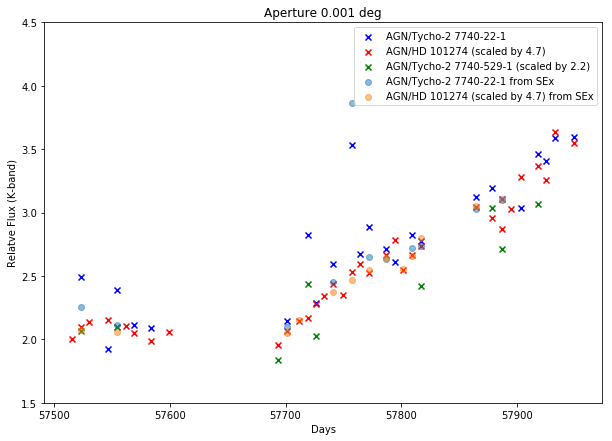

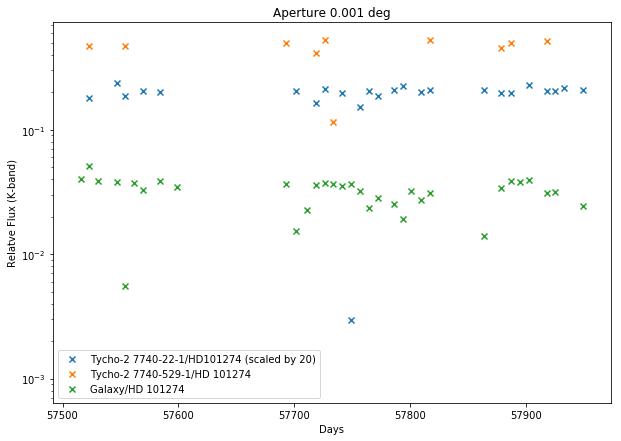

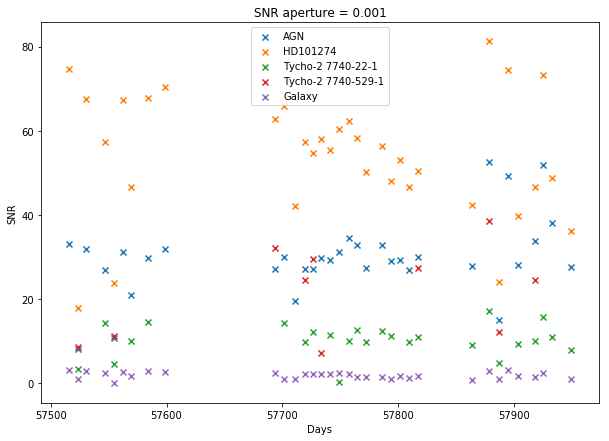

In [18]:
plt.figure(figsize=(10,7))
plt.scatter(date,np.array(flucompsta2),marker='x',\
            color='b',label='AGN/Tycho-2 7740-22-1')
plt.scatter(date,np.array(flucompsta1)*4.7,marker='x',\
            color='r',label='AGN/HD 101274 (scaled by 4.7)')
plt.scatter(date,np.array(flucompsta4)*2.2,marker='x',\
            color='g',label='AGN/Tycho-2 7740-529-1 (scaled by 2.2)')


plt.scatter(dataqua_1['time'],comp1(dataqua['flux_main'],datasta2['flux_main']),\
            marker='o',alpha=0.5,label='AGN/Tycho-2 7740-22-1 from SEx')
plt.scatter(dataqua_1['time'],comp1(dataqua['flux_main'],datasta1['flux_main'])*4.7,\
            marker='o',alpha=0.5,label='AGN/HD 101274 (scaled by 4.7) from SEx')

plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
plt.ylim([1.5,4.5])
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(date,np.array(flucompsta3),marker='x',\
            label='Tycho-2 7740-22-1/HD101274 (scaled by 20)')
plt.scatter(date,np.array(flucompsta6),marker='x',\
            label='Tycho-2 7740-529-1/HD 101274')
plt.scatter(date,np.array(flucompsta7),marker='x',\
            label='Galaxy/HD 101274')

plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
#plt.scatter(time,err)
plt.scatter(date,np.array(SNR1),marker='x',\
            label='AGN')
plt.scatter(date,np.array(SNR2),marker='x',\
            label='HD101274')

plt.scatter(date,np.array(SNR3),marker='x',\
            label='Tycho-2 7740-22-1')
plt.scatter(date,np.array(SNR4),marker='x',\
            label='Tycho-2 7740-529-1')
plt.scatter(date,np.array(SNR5),marker='x',\
            label='Galaxy')
plt.xlabel('Days')
plt.ylabel('SNR')
plt.title('SNR aperture = 0.001')
plt.legend()
plt.show()



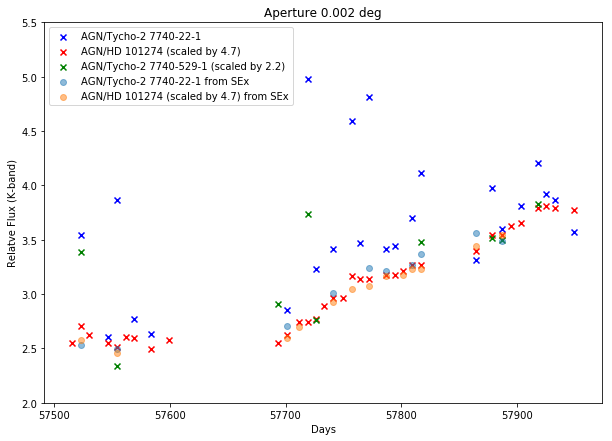

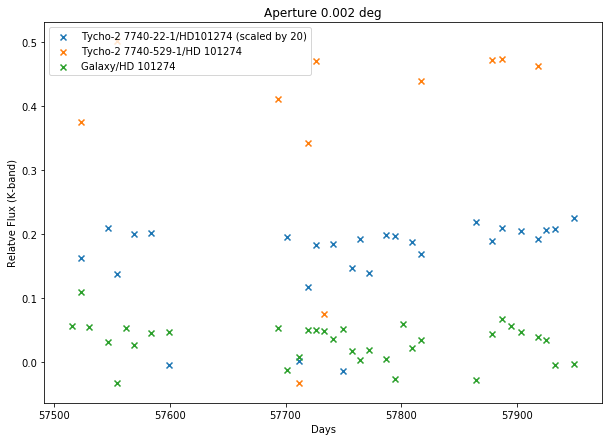

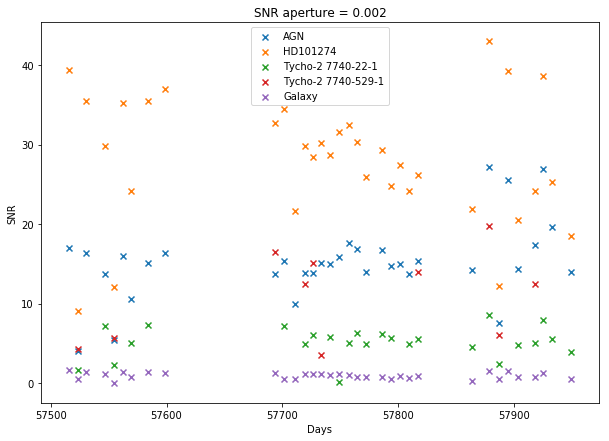

In [19]:
plt.figure(figsize=(10,7))
plt.scatter(date,np.array(flucompsta2_1),marker='x',\
            color='b',label='AGN/Tycho-2 7740-22-1')
plt.scatter(date,np.array(flucompsta1_1)*4.7,marker='x',\
            color='r',label='AGN/HD 101274 (scaled by 4.7)')
plt.scatter(date,np.array(flucompsta4_1)*2.2,marker='x',\
            color='g',label='AGN/Tycho-2 7740-529-1 (scaled by 2.2)')


plt.scatter(dataqua_1['time'],comp1(dataqua_1['flux_main'],datasta2_1['flux_main']),\
            marker='o',alpha=0.5,label='AGN/Tycho-2 7740-22-1 from SEx')
plt.scatter(dataqua_1['time'],comp1(dataqua_1['flux_main'],datasta1_1['flux_main'])*4.7,\
            marker='o',alpha=0.5,label='AGN/HD 101274 (scaled by 4.7) from SEx')

plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.002 deg')
plt.ylim([2,5.5])
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(date,np.array(flucompsta3_1),marker='x',\
            label='Tycho-2 7740-22-1/HD101274 (scaled by 20)')
plt.scatter(date,np.array(flucompsta6_1),marker='x',\
            label='Tycho-2 7740-529-1/HD 101274')
plt.scatter(date,np.array(flucompsta7_1),marker='x',\
            label='Galaxy/HD 101274')

plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.002 deg')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
#plt.scatter(time,err)
plt.scatter(date,np.array(SNR1_1),marker='x',\
            label='AGN')
plt.scatter(date,np.array(SNR2_1),marker='x',\
            label='HD101274')

plt.scatter(date,np.array(SNR3_1),marker='x',\
            label='Tycho-2 7740-22-1')
plt.scatter(date,np.array(SNR4_1),marker='x',\
            label='Tycho-2 7740-529-1')
plt.scatter(date,np.array(SNR5_1),marker='x',\
            label='Galaxy')
plt.xlabel('Days')
plt.ylabel('SNR')
plt.title('SNR aperture = 0.002')
plt.legend()
plt.show()



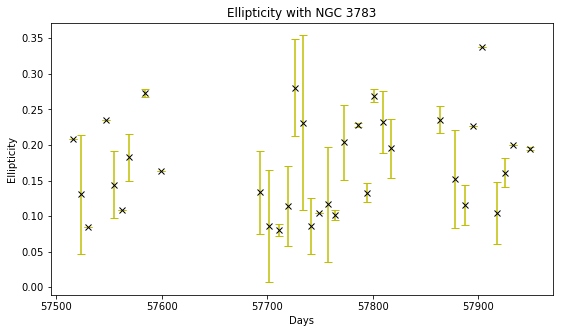

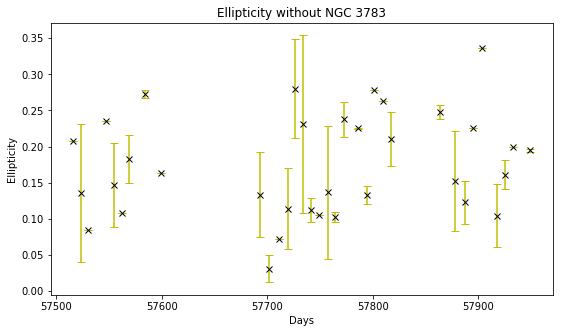

In [20]:
date_ell = np.zeros(len(quas))
ell = np.zeros(len(quas),dtype=float)
ell_std = np.zeros(len(quas))

for i in range(len(quas)):
    date_ell[i] = dataqua['time'][i]
    ell[i] = np.nanmean((dataqua['Ellipticity'][i],datasta1['Ellipticity'][i],\
                       datasta2['Ellipticity'][i],datasta3['Ellipticity'][i]))
    ell_std[i] = np.nanstd((dataqua['Ellipticity'][i],datasta1['Ellipticity'][i],\
                       datasta2['Ellipticity'][i],datasta3['Ellipticity'][i]))

plt.figure(figsize=(9,5))
plt.errorbar(date_ell,ell,yerr=ell_std,fmt='x',ecolor='y',color='black',capsize=4)
plt.xlabel('Days')
plt.ylabel('Ellipticity')
plt.title('Ellipticity with NGC 3783')
plt.show()

date_ell_1 = np.zeros(len(quas))
ell_1 = np.zeros(len(quas),dtype=float)
ell_std_1 = np.zeros(len(quas))

for i in range(len(quas)):
    date_ell_1[i] = dataqua['time'][i]
    ell_1[i] = np.nanmean((datasta1['Ellipticity'][i],\
                       datasta2['Ellipticity'][i],datasta3['Ellipticity'][i]))
    ell_std_1[i] = np.nanstd((datasta1['Ellipticity'][i],\
                       datasta2['Ellipticity'][i],datasta3['Ellipticity'][i]))

plt.figure(figsize=(9,5))
plt.errorbar(date_ell_1,ell_1,yerr=ell_std_1,fmt='x',ecolor='y',color='black',capsize=4)
plt.xlabel('Days')
plt.ylabel('Ellipticity')
plt.title('Ellipticity without NGC 3783')
plt.show()

The ellipticity and the assiociated standard deviation on the ellipticity. With the center AGN and without.

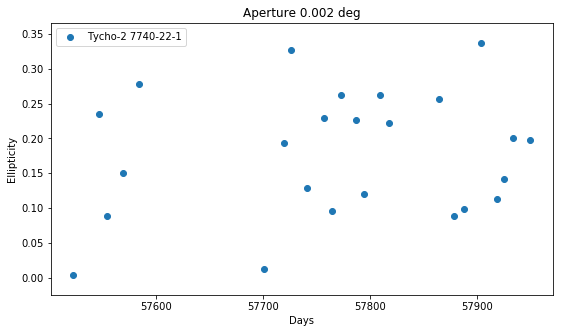

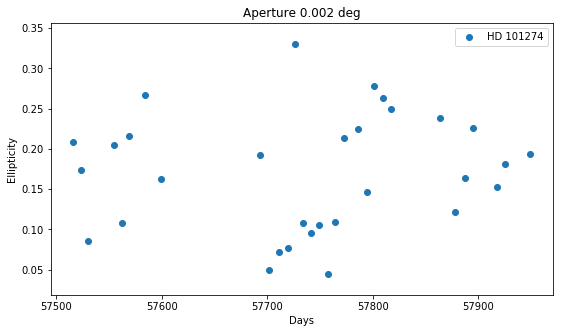

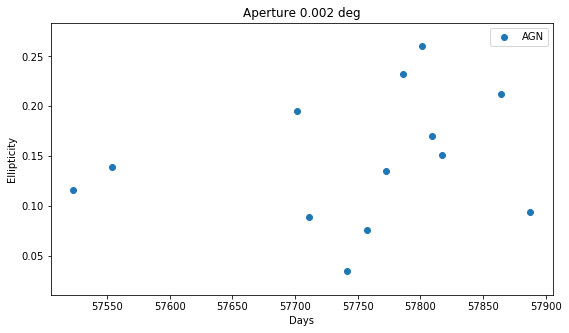

In [21]:
plt.figure(figsize=(9,5))
plt.scatter(datasta2_1['time'],datasta2_1['Ellipticity'],marker='o',\
            label='Tycho-2 7740-22-1')

plt.xlabel('Days')
plt.ylabel('Ellipticity')
plt.title('Aperture 0.002 deg')
plt.legend()
plt.show()

plt.figure(figsize=(9,5))
plt.scatter(datasta1_1['time'],datasta1_1['Ellipticity'],marker='o',\
            label='HD 101274')
plt.xlabel('Days')
plt.ylabel('Ellipticity')
plt.title('Aperture 0.002 deg')
plt.legend()
plt.show()

plt.figure(figsize=(9,5))
plt.scatter(dataqua_1['time'],dataqua_1['Ellipticity'],marker='o',\
            label='AGN')
plt.xlabel('Days')
plt.ylabel('Ellipticity')
plt.title('Aperture 0.002 deg')
plt.legend()
plt.show()

Individual frames are looked at to observe whether or not it is the calibration that is the issue. It does not appear to be a general problem in the calibration at 0.002 deg radius for the aperture. 

34
Frame nr.  0
AGN image 1139.2


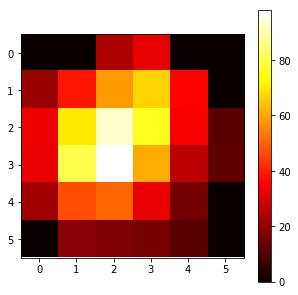

AGN image 1632.7


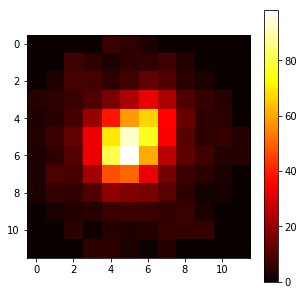

HD101274 image 2549.4


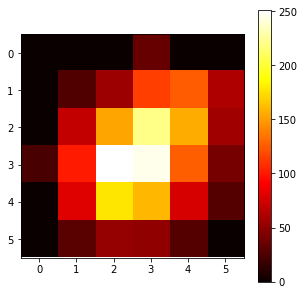

HD101274 image 3056.3


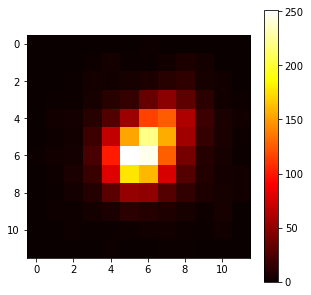

Tycho-2 7740-22-1 image 477.2


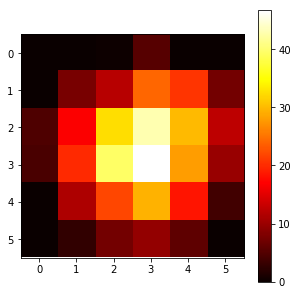

Tycho-2 7740-22-1 image 421.9


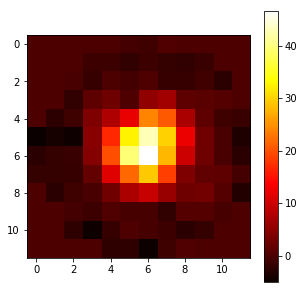

Frame nr.  1
AGN image 3377.4


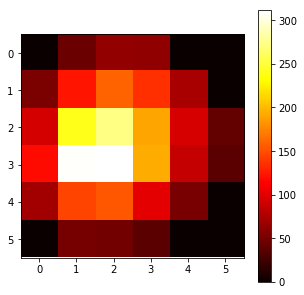

AGN image 4758.6


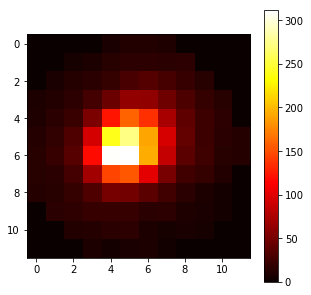

HD101274 image 7536.5


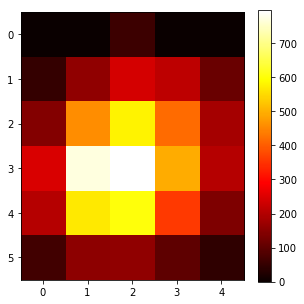

HD101274 image 8585.5


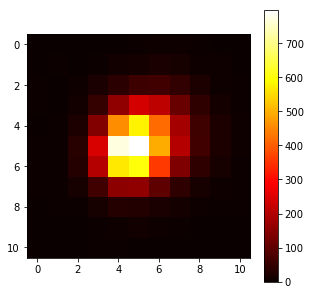

Tycho-2 7740-22-1 image nan


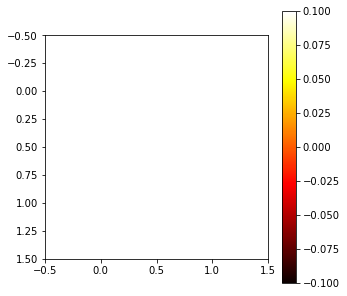

Tycho-2 7740-22-1 image nan


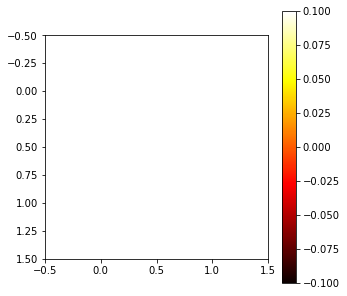

Frame nr.  2
AGN image 3238.0


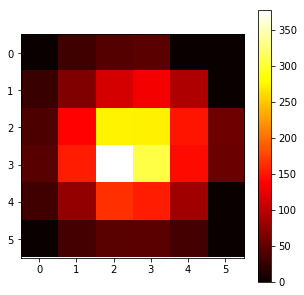

AGN image 4536.2


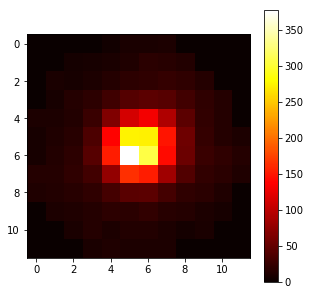

HD101274 image 7365.6


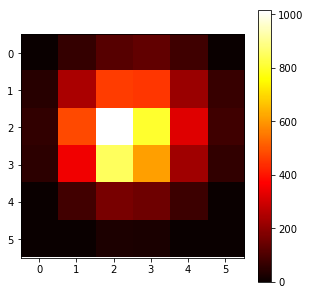

HD101274 image 8128.9


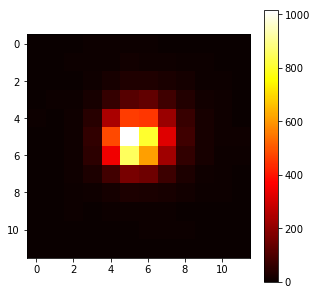

Tycho-2 7740-22-1 image 1509.7


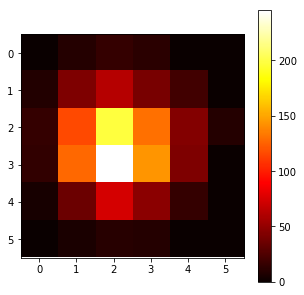

Tycho-2 7740-22-1 image 1588.2


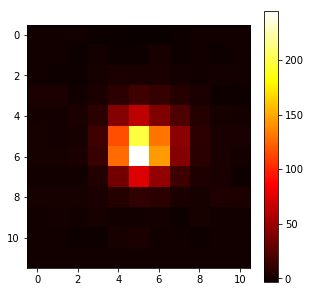

Frame nr.  3
AGN image 2936.8


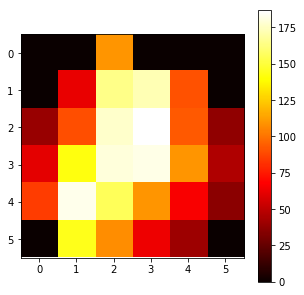

AGN image 4726.8


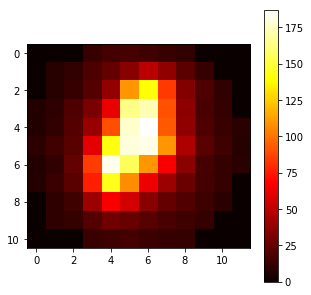

HD101274 image 6050.2


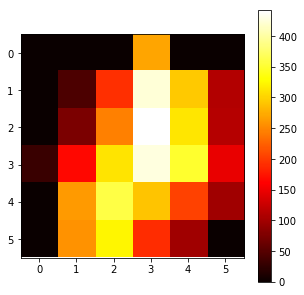

HD101274 image 8010.9


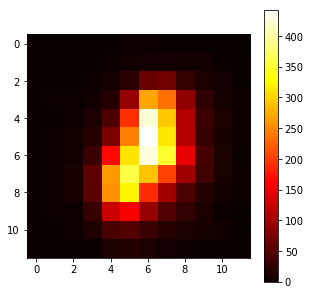

Tycho-2 7740-22-1 image 1285.7


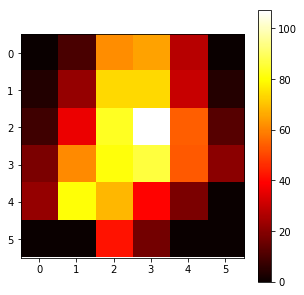

Tycho-2 7740-22-1 image 1463.2


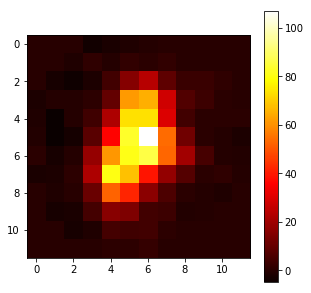

Frame nr.  4
AGN image 2239.2


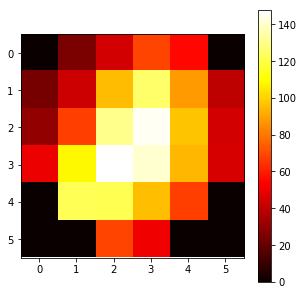

AGN image 3540.1


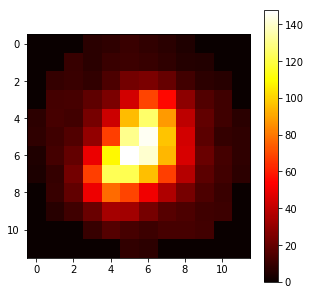

HD101274 image 5140.6


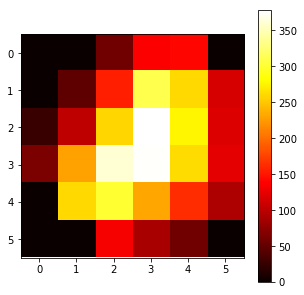

HD101274 image 6414.6


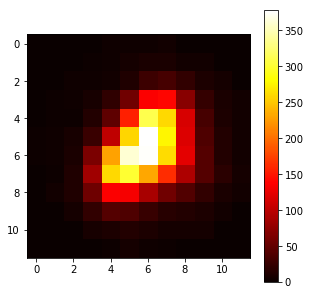

Tycho-2 7740-22-1 image 1059.5


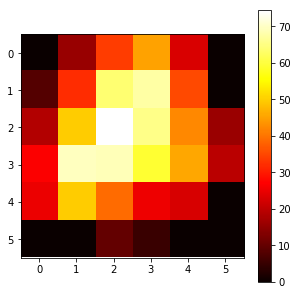

Tycho-2 7740-22-1 image 1279.0


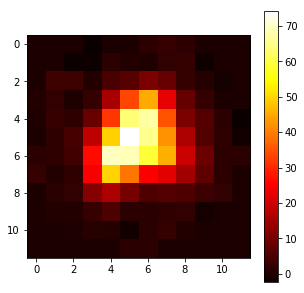

Frame nr.  5
AGN image 1580.8


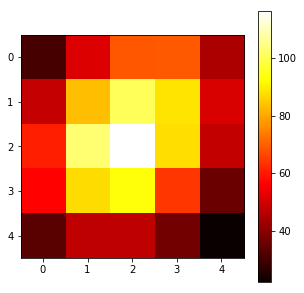

AGN image 2547.0


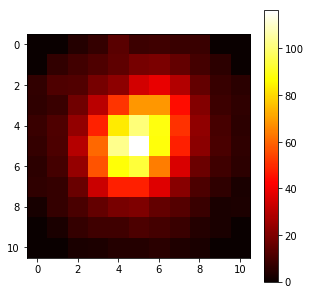

HD101274 image 2585.2


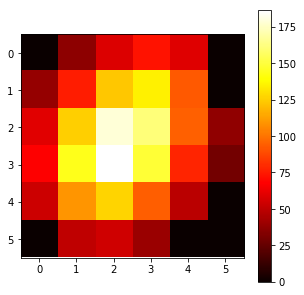

HD101274 image 3376.2


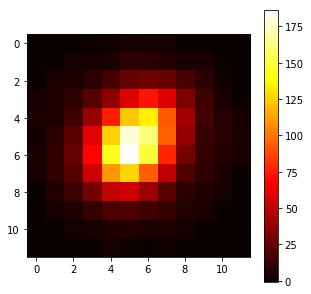

Tycho-2 7740-22-1 image 509.3


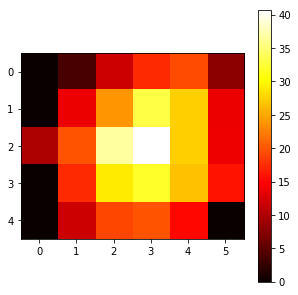

Tycho-2 7740-22-1 image 707.9


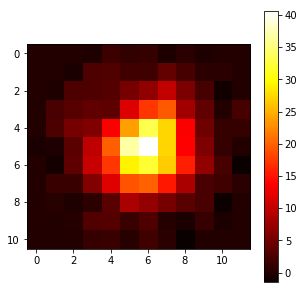

Frame nr.  6
AGN image 2897.0


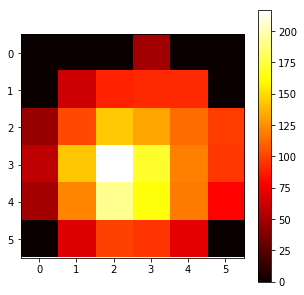

AGN image 4872.2


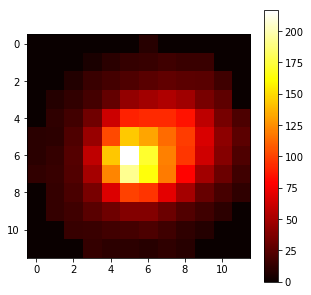

HD101274 image 6330.3


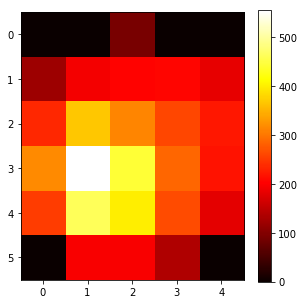

HD101274 image 8972.9


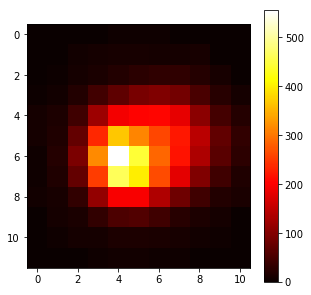

Tycho-2 7740-22-1 image 1506.1


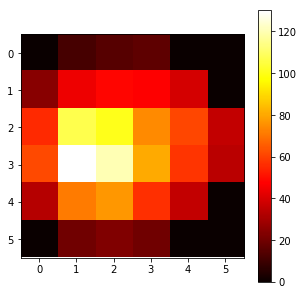

Tycho-2 7740-22-1 image 1872.7


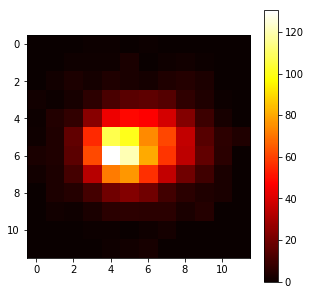

Frame nr.  7
AGN image 3211.7


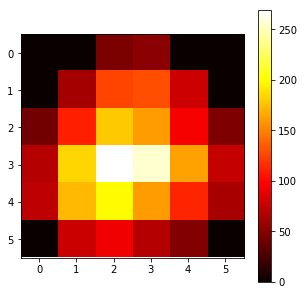

AGN image 4599.6


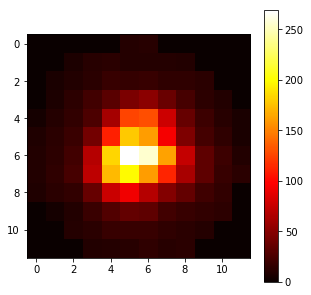

HD101274 image 6202.4


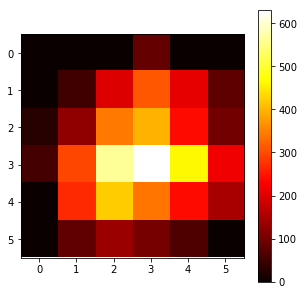

HD101274 image 7289.7


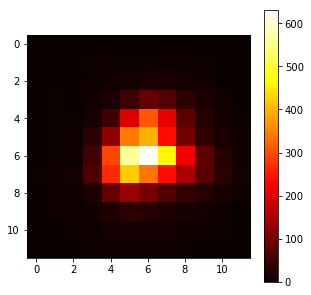

Tycho-2 7740-22-1 image 1237.2


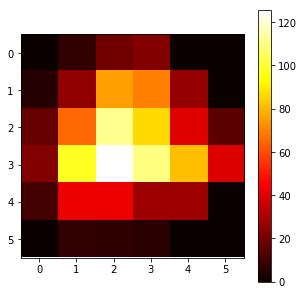

Tycho-2 7740-22-1 image 1346.2


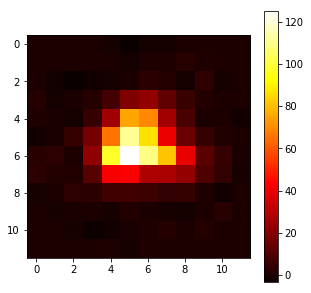

Frame nr.  8
AGN image 5749.5


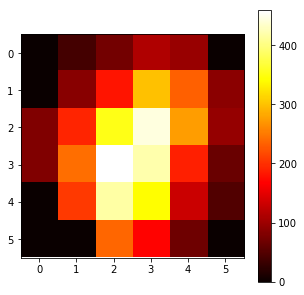

AGN image 7682.3


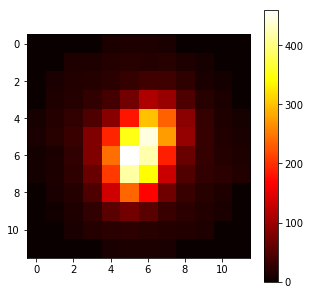

HD101274 image 8291.4


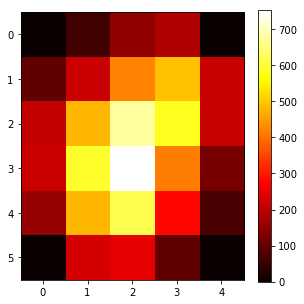

HD101274 image 9469.6


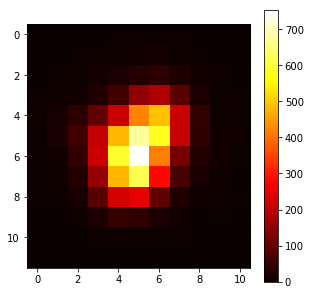

Tycho-2 7740-22-1 image 1689.0


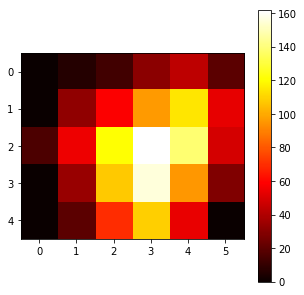

Tycho-2 7740-22-1 image 1961.0


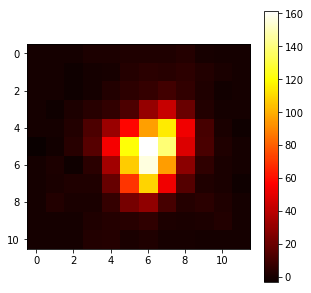

Frame nr.  9
AGN image 3607.4


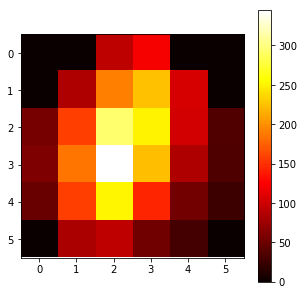

AGN image 5095.0


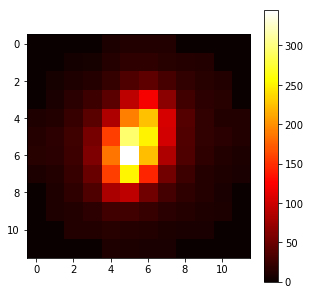

HD101274 image 8455.0


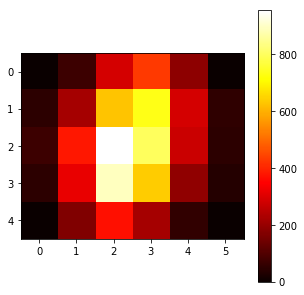

HD101274 image 9393.2


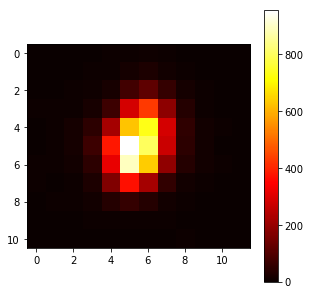

Tycho-2 7740-22-1 image nan


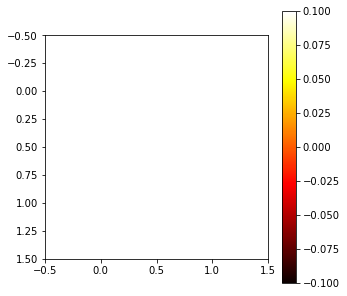

Tycho-2 7740-22-1 image nan


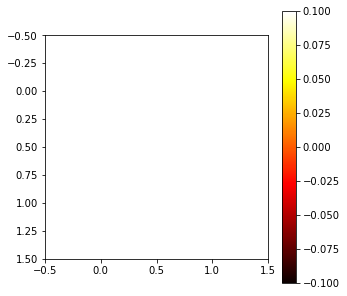

Frame nr.  10
AGN image 3243.2


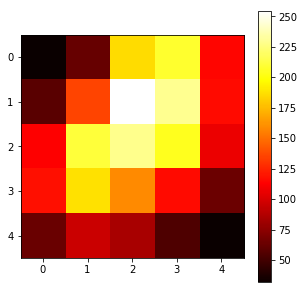

AGN image 4762.3


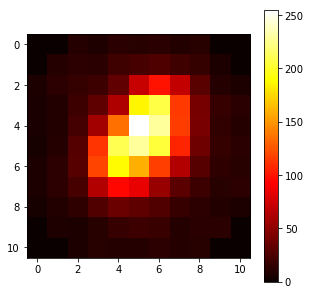

HD101274 image 5574.4


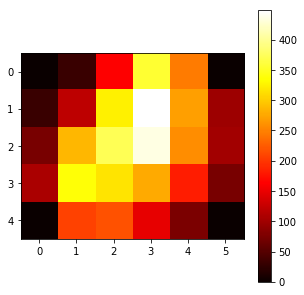

HD101274 image 6855.5


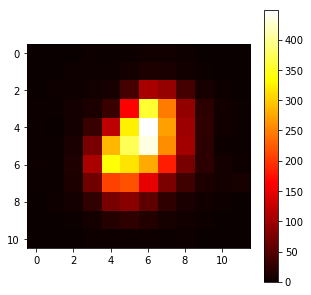

Tycho-2 7740-22-1 image 1168.6


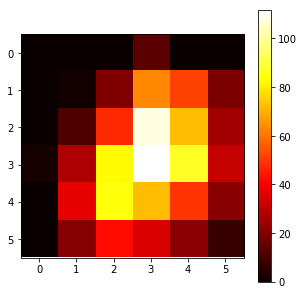

Tycho-2 7740-22-1 image 1157.7


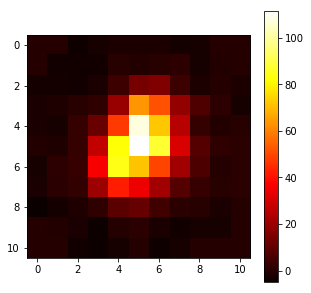

Frame nr.  11
AGN image 2960.3


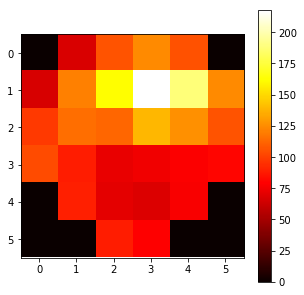

AGN image 5166.2


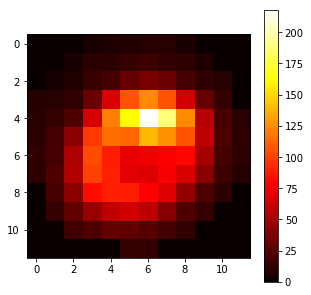

HD101274 image 3920.1


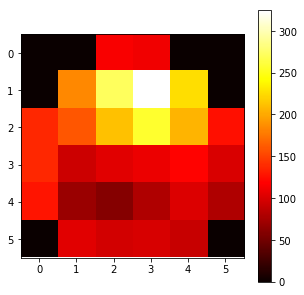

HD101274 image 6428.7


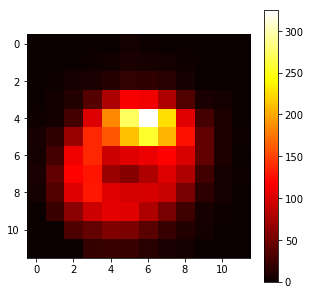

Tycho-2 7740-22-1 image 823.0


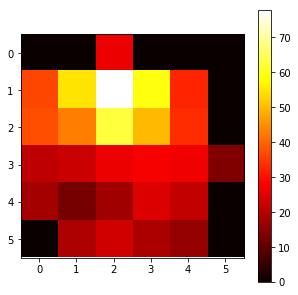

Tycho-2 7740-22-1 image 1447.5


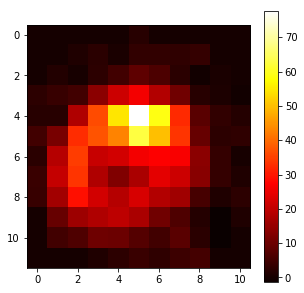

Frame nr.  12
AGN image 3667.5


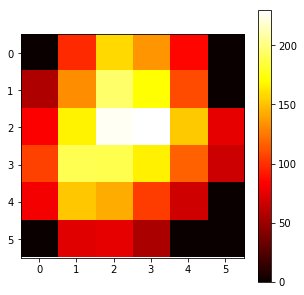

AGN image 5454.4


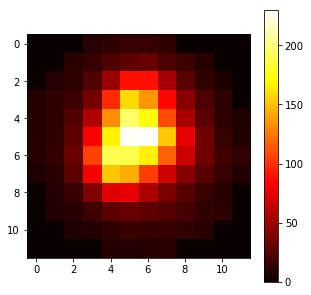

HD101274 image 5125.0


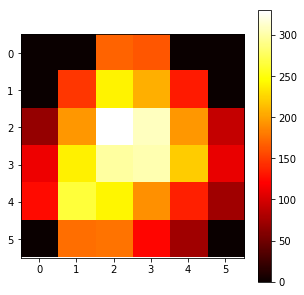

HD101274 image 6754.9


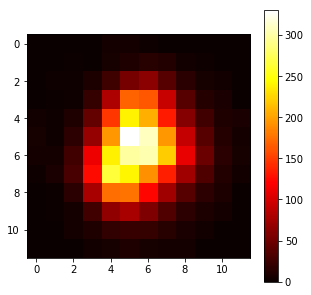

Tycho-2 7740-22-1 image 1060.3


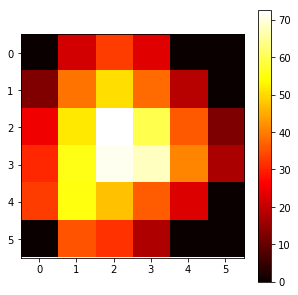

Tycho-2 7740-22-1 image 1297.7


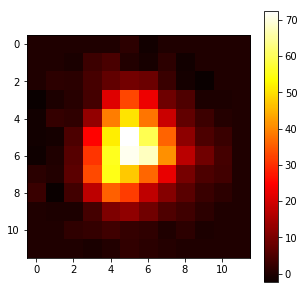

Frame nr.  13
AGN image 2114.6


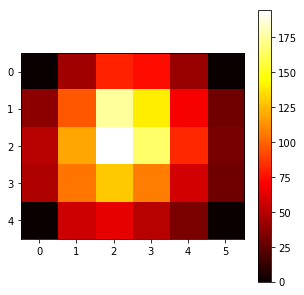

AGN image 3319.3


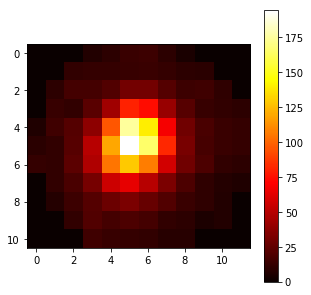

HD101274 image 4637.4


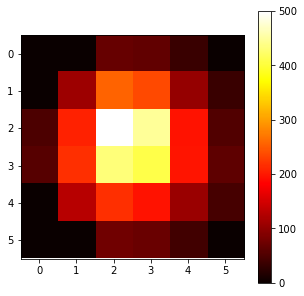

HD101274 image 5679.2


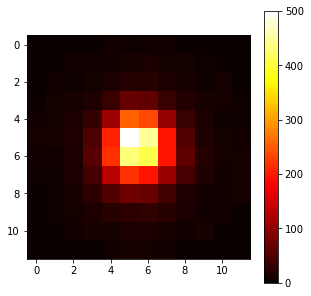

Tycho-2 7740-22-1 image nan


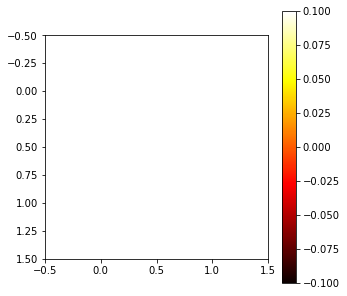

Tycho-2 7740-22-1 image 4.4


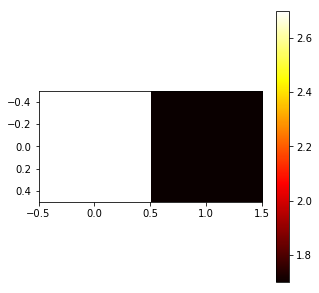

Frame nr.  14
AGN image 3196.1


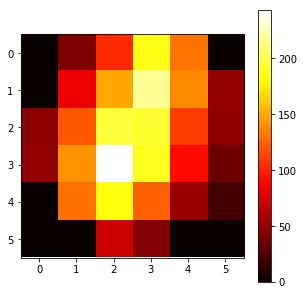

AGN image 4543.0


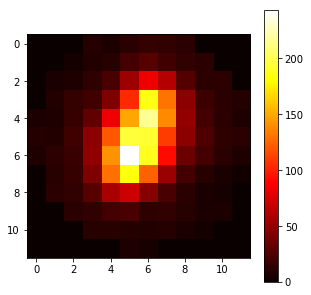

HD101274 image 5902.6


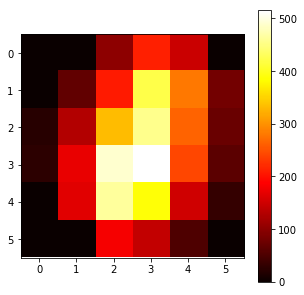

HD101274 image 6638.3


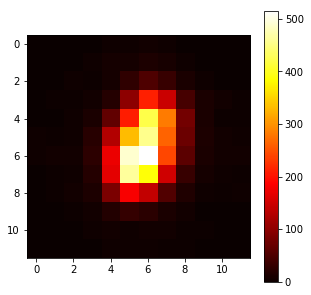

Tycho-2 7740-22-1 image nan


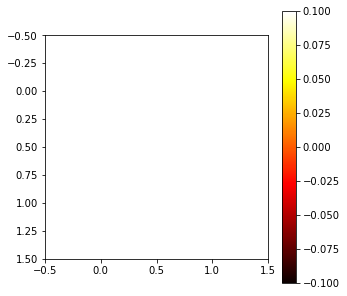

Tycho-2 7740-22-1 image nan


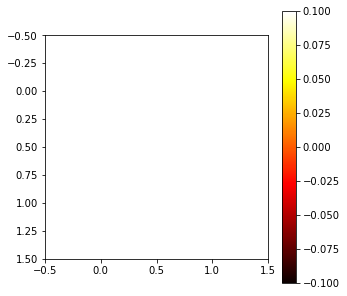

Frame nr.  15
AGN image 3576.3


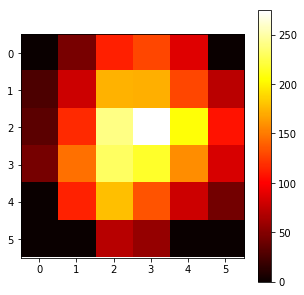

AGN image 5107.2


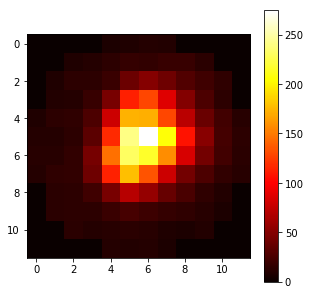

HD101274 image 6474.3


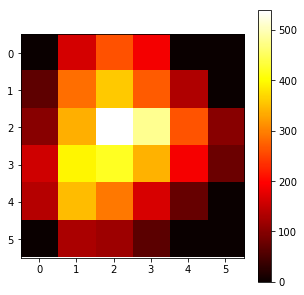

HD101274 image 7647.1


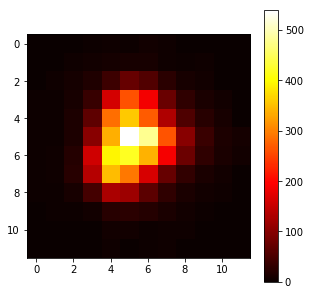

Tycho-2 7740-22-1 image 1339.0


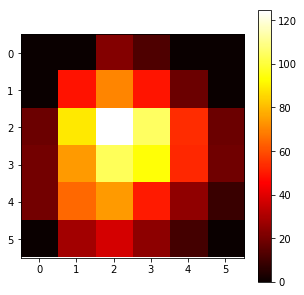

Tycho-2 7740-22-1 image 1470.5


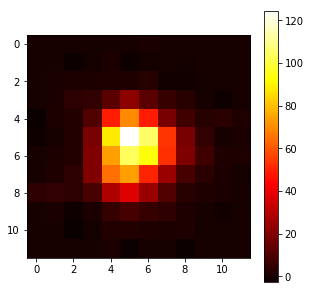

Frame nr.  16
AGN image 846.0


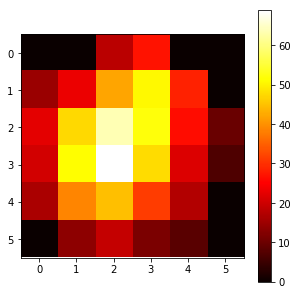

AGN image 1263.3


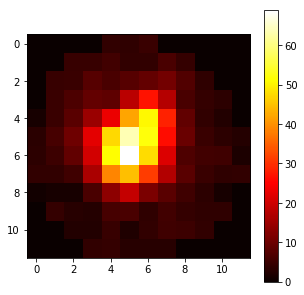

HD101274 image 1896.0


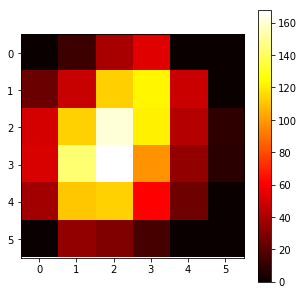

HD101274 image 2192.1


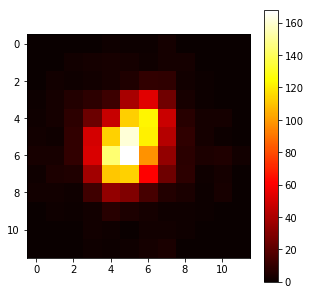

Tycho-2 7740-22-1 image 339.1


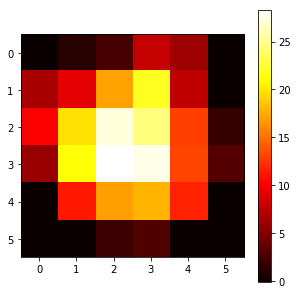

Tycho-2 7740-22-1 image 356.9


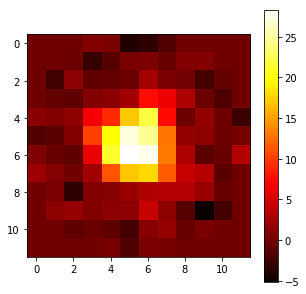

Frame nr.  17
AGN image 3008.0


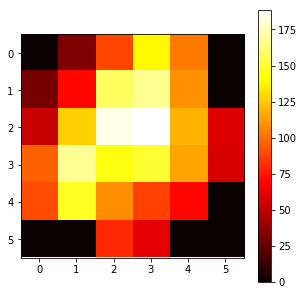

AGN image 4490.3


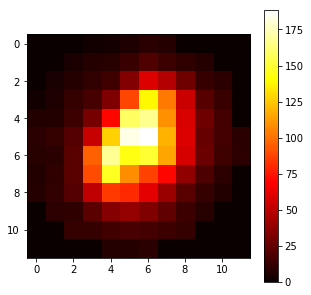

HD101274 image 4643.5


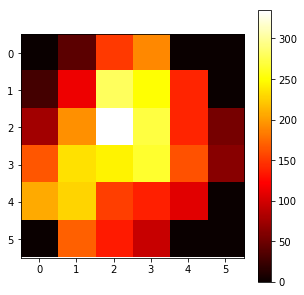

HD101274 image 6206.1


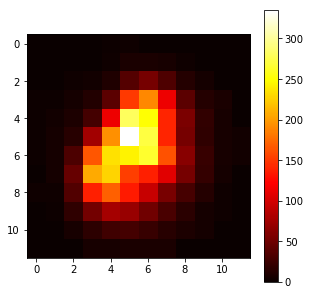

Tycho-2 7740-22-1 image 964.4


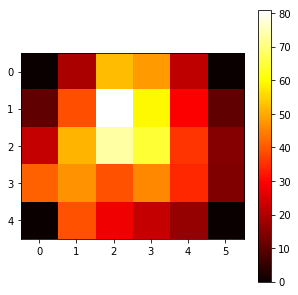

Tycho-2 7740-22-1 image 1354.4


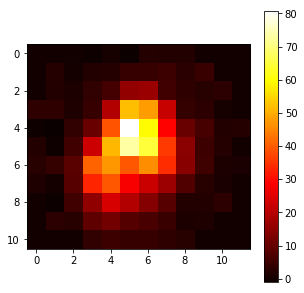

Frame nr.  18
AGN image 3207.1


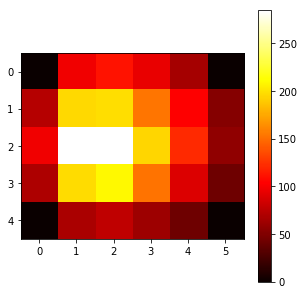

AGN image 4634.8


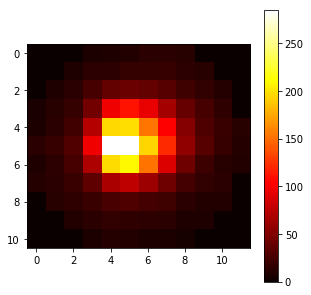

HD101274 image 6446.7


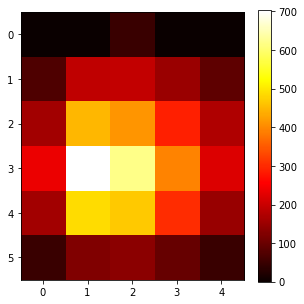

HD101274 image 7524.8


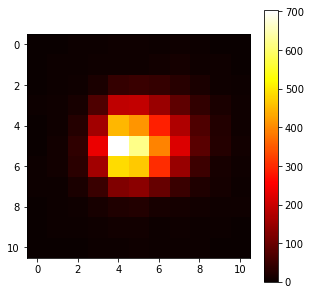

Tycho-2 7740-22-1 image nan


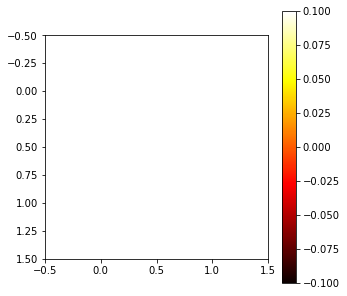

Tycho-2 7740-22-1 image nan


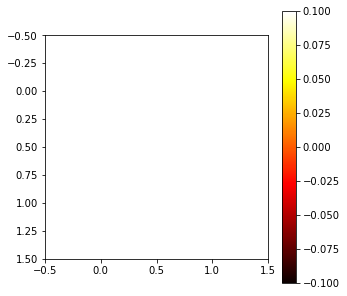

Frame nr.  19
AGN image 3012.9


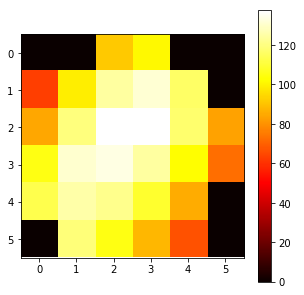

AGN image 6292.8


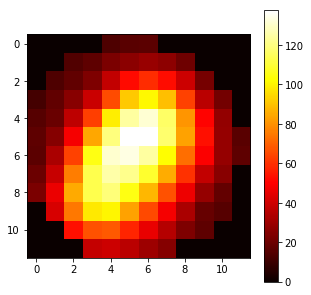

HD101274 image 4321.4


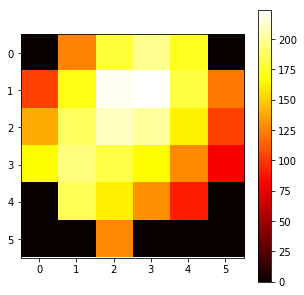

HD101274 image 8084.9


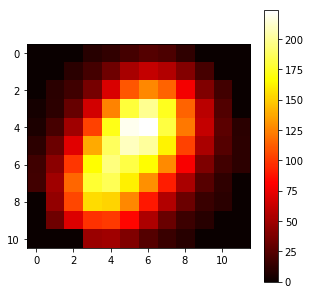

Tycho-2 7740-22-1 image 992.2


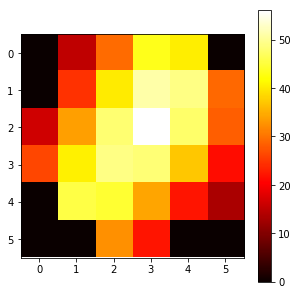

Tycho-2 7740-22-1 image 1651.0


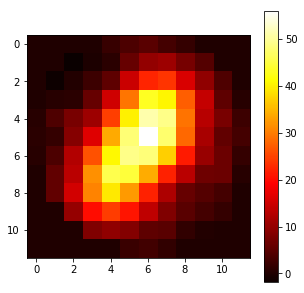

Frame nr.  20
AGN image 2922.0


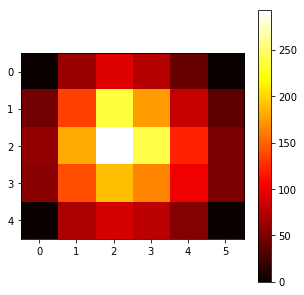

AGN image 4229.2


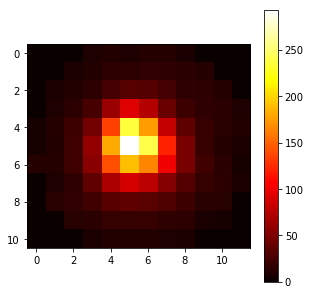

HD101274 image 6337.4


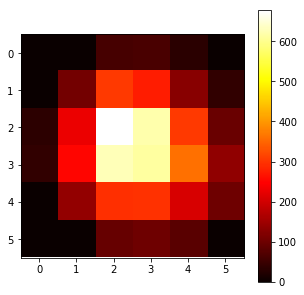

HD101274 image 7255.3


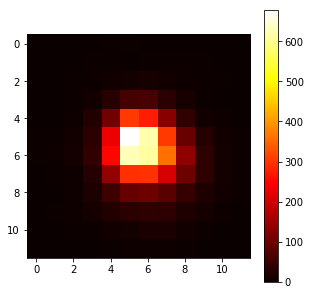

Tycho-2 7740-22-1 image 1034.3


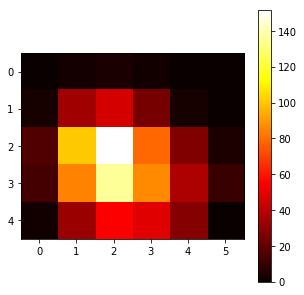

Tycho-2 7740-22-1 image 850.2


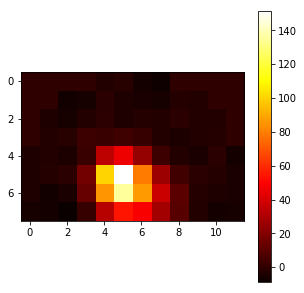

Frame nr.  21
AGN image 3440.9


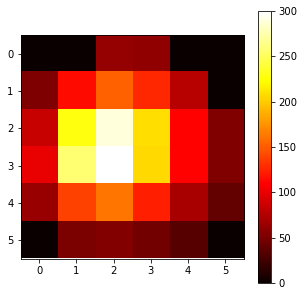

AGN image 4948.7


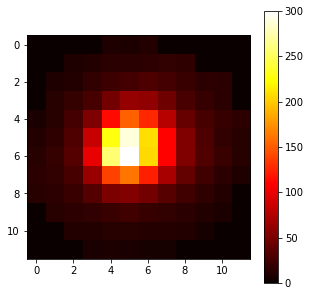

HD101274 image 7555.5


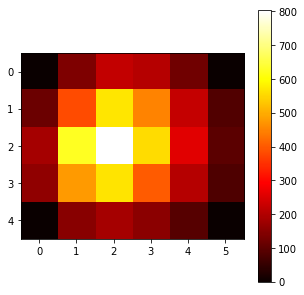

HD101274 image 8861.0


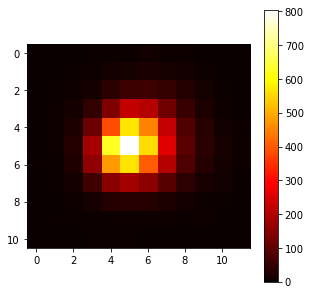

Tycho-2 7740-22-1 image nan


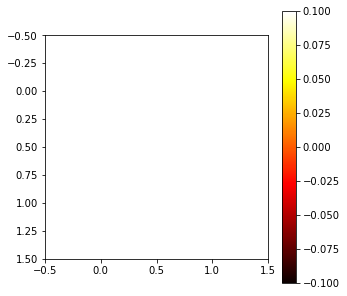

Tycho-2 7740-22-1 image nan


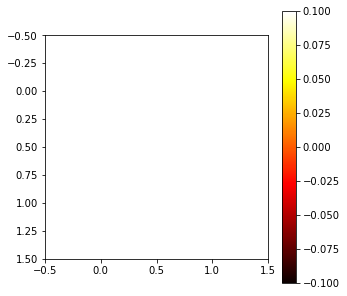

Frame nr.  22
AGN image 3358.8


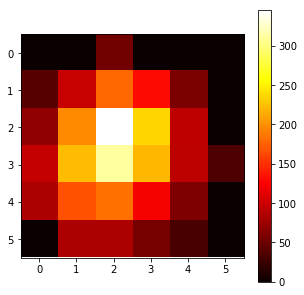

AGN image 4755.3


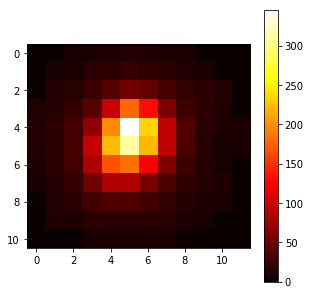

HD101274 image 6710.2


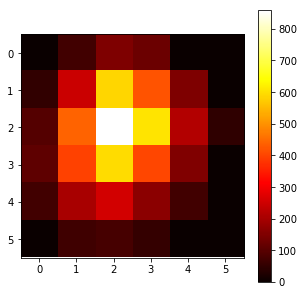

HD101274 image 7540.5


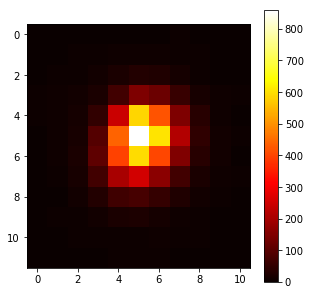

Tycho-2 7740-22-1 image 20.0


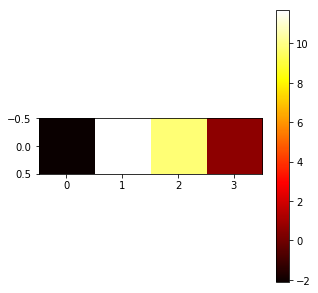

Tycho-2 7740-22-1 image -104.2


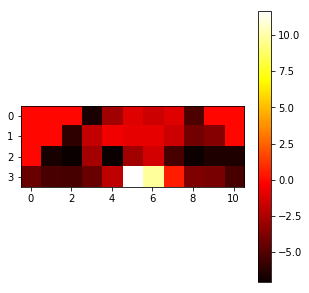

Frame nr.  23
AGN image 2938.1


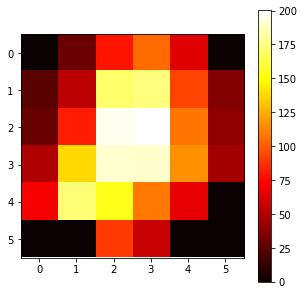

AGN image 4209.0


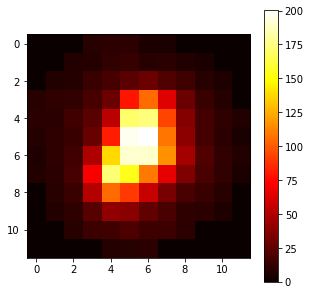

HD101274 image 5175.6


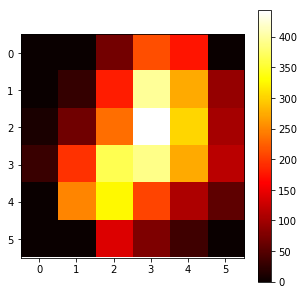

HD101274 image 6054.7


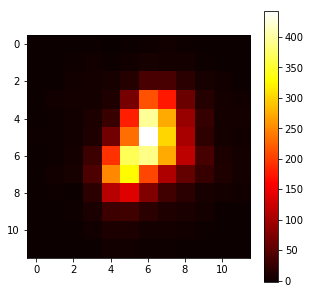

Tycho-2 7740-22-1 image 1041.3


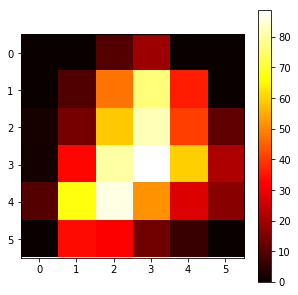

Tycho-2 7740-22-1 image 1136.6


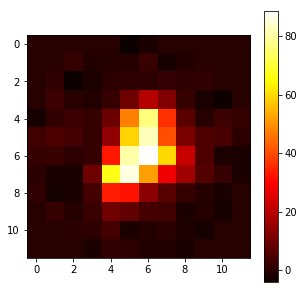

Frame nr.  24
AGN image 3473.0


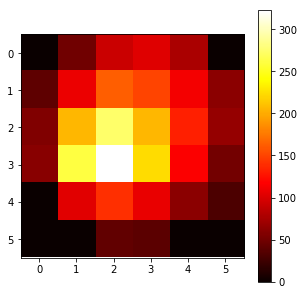

AGN image 4959.8


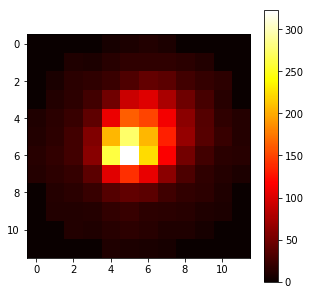

HD101274 image 7938.8


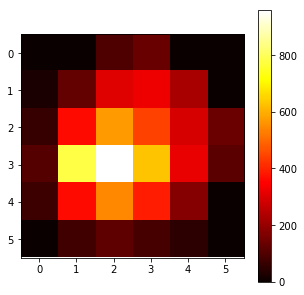

HD101274 image 9057.0


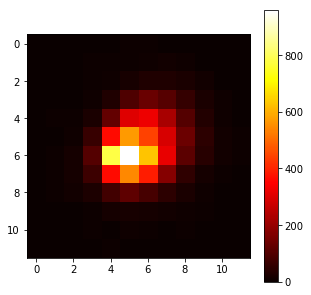

Tycho-2 7740-22-1 image nan


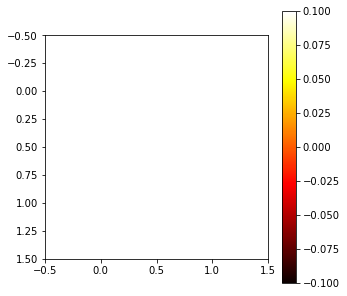

Tycho-2 7740-22-1 image -42.6


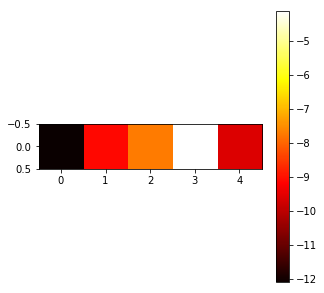

Frame nr.  25
AGN image 5801.4


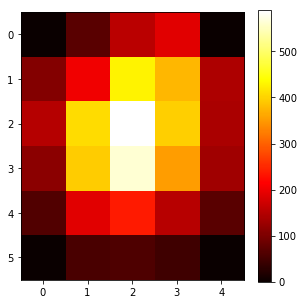

AGN image 7730.5


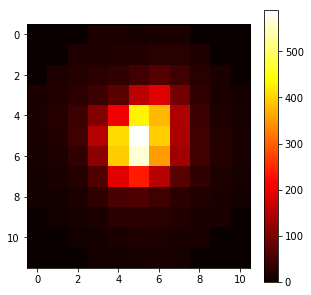

HD101274 image 9230.4


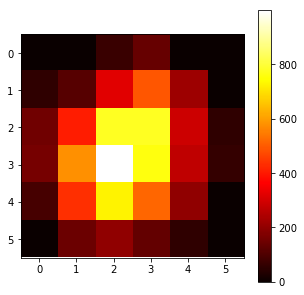

HD101274 image 10248.3


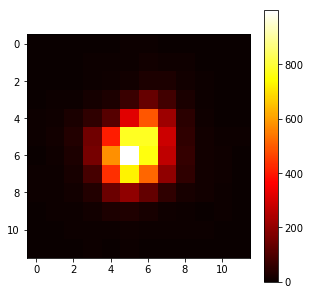

Tycho-2 7740-22-1 image 1818.5


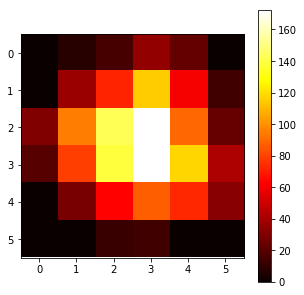

Tycho-2 7740-22-1 image 1943.8


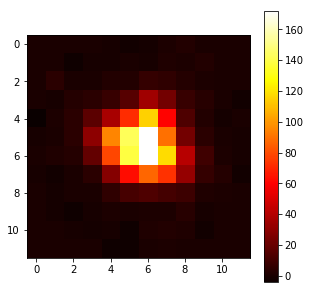

Frame nr.  26
AGN image 4134.9


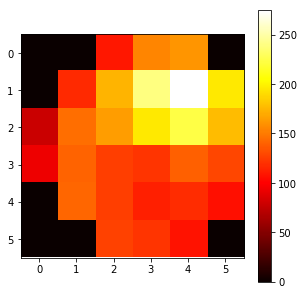

AGN image 7162.3


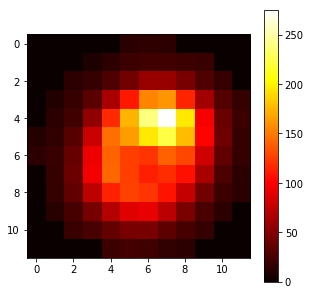

HD101274 image 5340.9


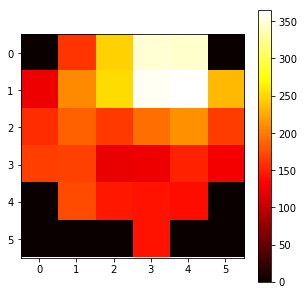

HD101274 image 8885.2


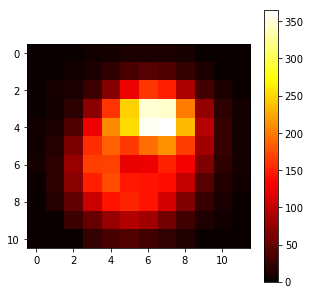

Tycho-2 7740-22-1 image 1152.7


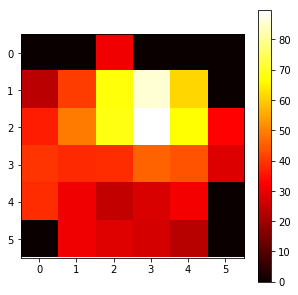

Tycho-2 7740-22-1 image 1853.5


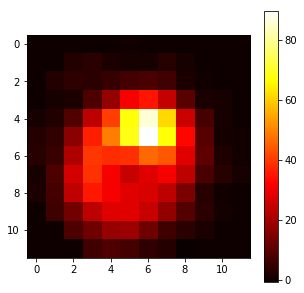

Frame nr.  27
AGN image 3115.9


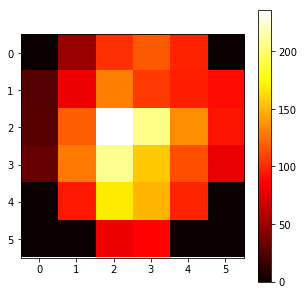

AGN image 4833.8


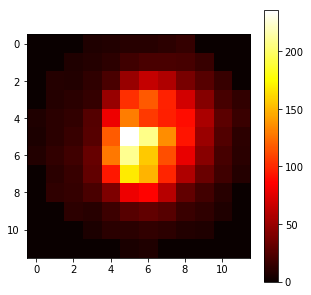

HD101274 image 5264.3


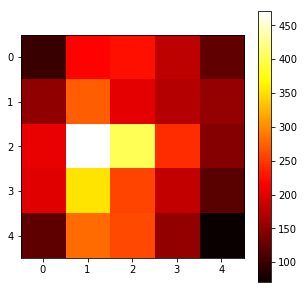

HD101274 image 7148.8


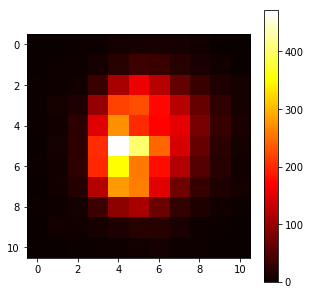

Tycho-2 7740-22-1 image 1193.8


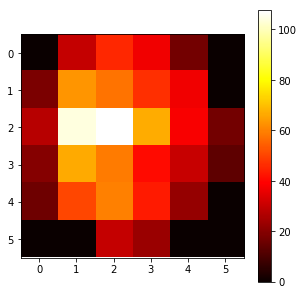

Tycho-2 7740-22-1 image 1402.6


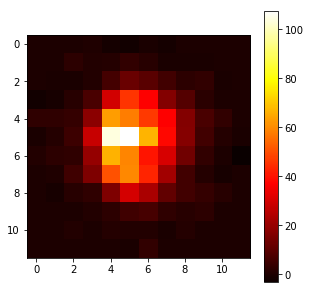

Frame nr.  28
AGN image 2901.1


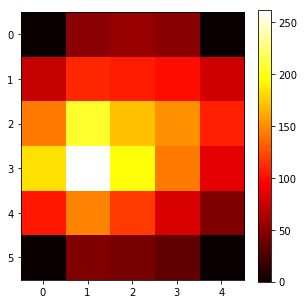

AGN image 4383.2


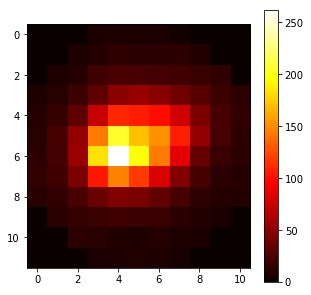

HD101274 image 6969.8


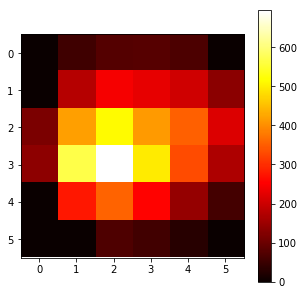

HD101274 image 8066.5


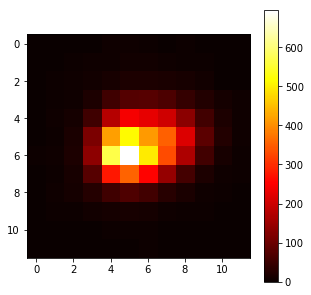

Tycho-2 7740-22-1 image nan


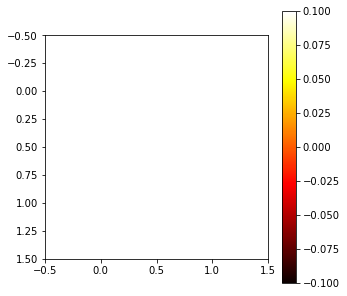

Tycho-2 7740-22-1 image nan


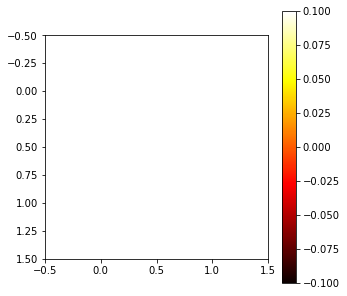

Frame nr.  29
AGN image 3541.6


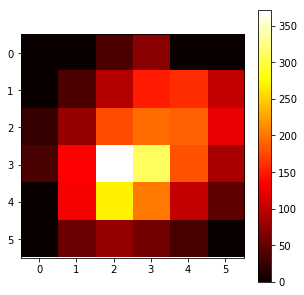

AGN image 4867.6


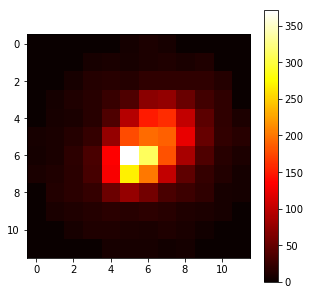

HD101274 image 6239.0


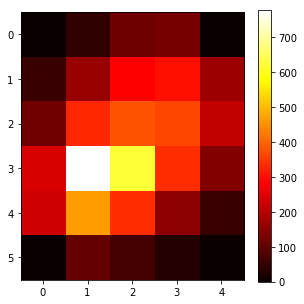

HD101274 image 7194.9


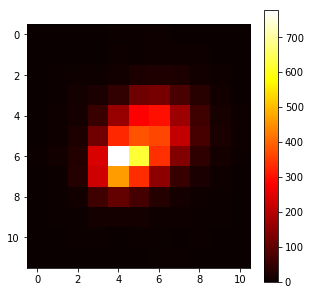

Tycho-2 7740-22-1 image 1307.3


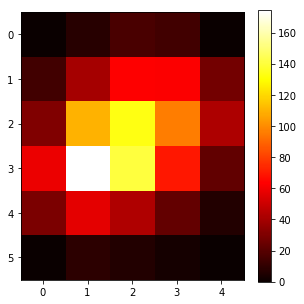

Tycho-2 7740-22-1 image 1426.8


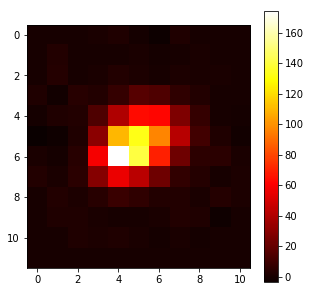

Frame nr.  30
AGN image 3204.0


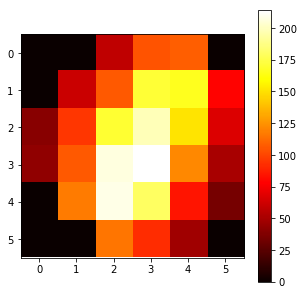

AGN image 4811.3


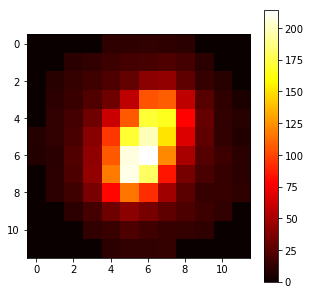

HD101274 image 7581.6


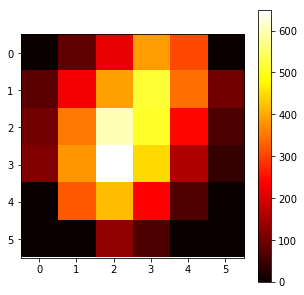

HD101274 image 9070.9


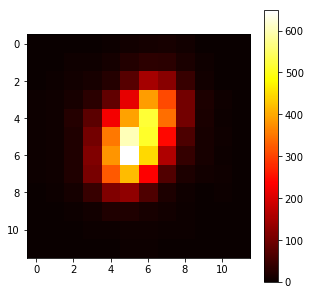

Tycho-2 7740-22-1 image 1533.7


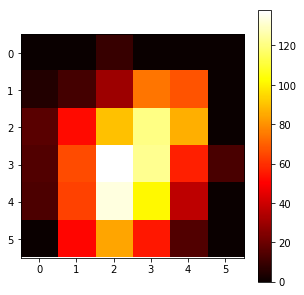

Tycho-2 7740-22-1 image 1829.9


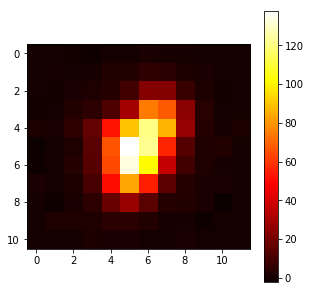

Frame nr.  31
AGN image 5400.7


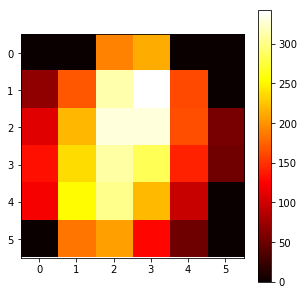

AGN image 7567.0


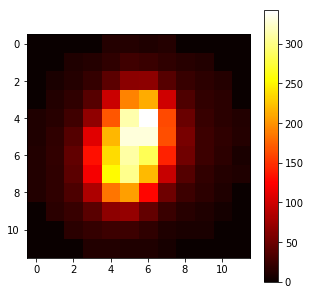

HD101274 image 8372.3


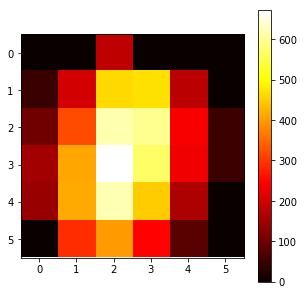

HD101274 image 9796.4


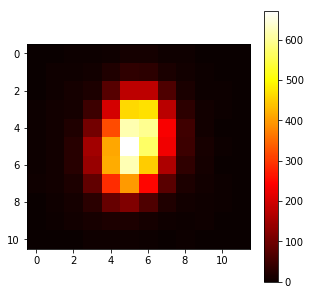

Tycho-2 7740-22-1 image nan


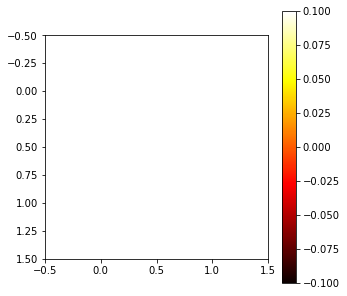

Tycho-2 7740-22-1 image nan


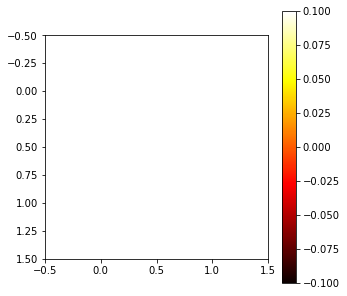

Frame nr.  32
AGN image 3797.4


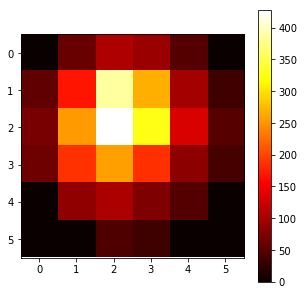

AGN image 5412.0


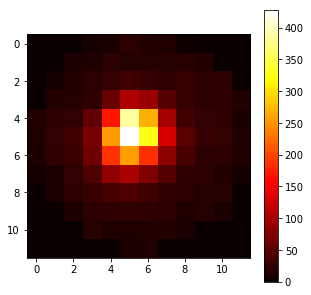

HD101274 image 7052.3


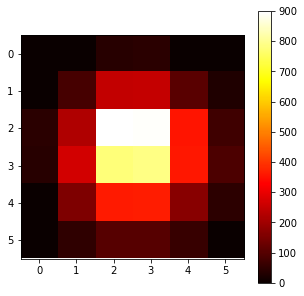

HD101274 image 8036.3


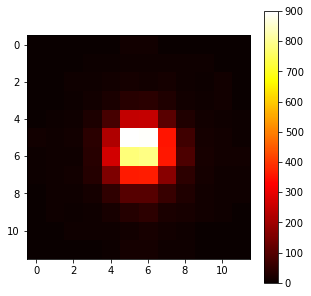

Tycho-2 7740-22-1 image 1074.3


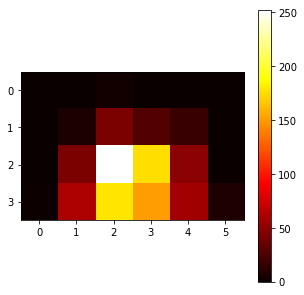

Tycho-2 7740-22-1 image 1179.6


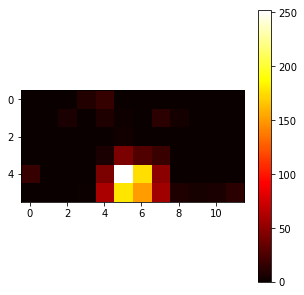

Frame nr.  33
AGN image 3032.7


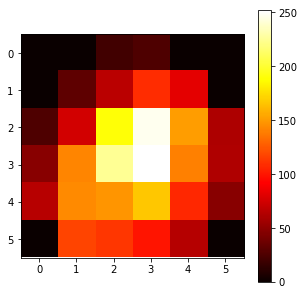

AGN image 4266.1


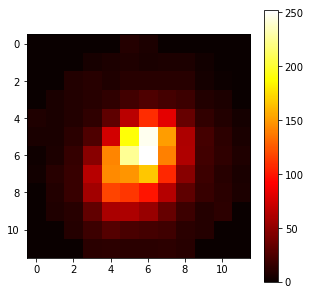

HD101274 image 5657.2


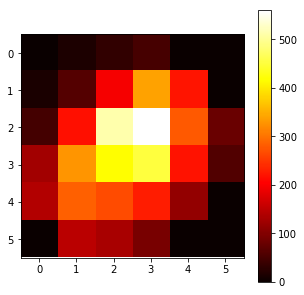

HD101274 image 6393.7


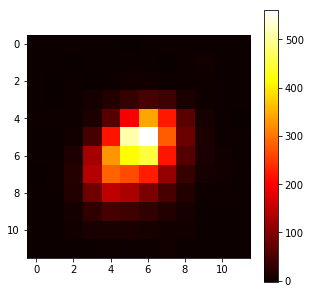

Tycho-2 7740-22-1 image 1051.9


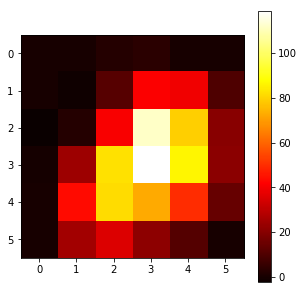

Tycho-2 7740-22-1 image 887.0


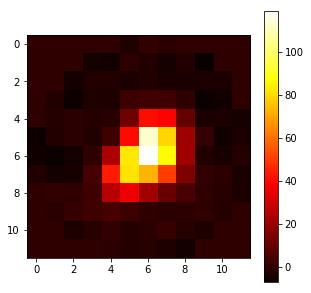

In [22]:
aperture1 = 0.001
flu = []
aperture2 = 0.002
flu_1 = []
print len(quas)
for i in range(len(quas)):
    print 'Frame nr. ', i
    header = pyfits.getheader(quas[i])
    a1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (qua1_RA_WORLD,qua1_DEC_WORLD),aperture1)[0]
    a2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta1_RA_WORLD,sta1_DEC_WORLD),aperture1)[0]
    a3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta2_RA_WORLD,sta2_DEC_WORLD),aperture1)[0]
    a1_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (qua1_RA_WORLD,qua1_DEC_WORLD),aperture2)[0]
    a2_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta1_RA_WORLD,sta1_DEC_WORLD),aperture2)[0]
    a3_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
               (sta2_RA_WORLD,sta2_DEC_WORLD),aperture2)[0]
    print 'AGN image', np.sum(a1)
    plt.figure(figsize=(5,5))
    plt.imshow(a1,cmap='hot')
    plt.colorbar()
    #plt.xlim([260,290])
    #plt.ylim([290,310])
    plt.show()
    print 'AGN image', np.sum(a1_1)
    plt.figure(figsize=(5,5))
    plt.imshow(a1_1,cmap='hot')
    plt.colorbar()
    #plt.xlim([260,290])
    #plt.ylim([290,310])
    plt.show()
    
    print 'HD101274 image', np.sum(a2)
    plt.figure(figsize=(5,5))
    plt.imshow(a2,cmap='hot')
    plt.colorbar()
    #plt.xlim([260,290])
    #plt.ylim([290,310])
    plt.show()
    print 'HD101274 image', np.sum(a2_1)
    plt.figure(figsize=(5,5))
    plt.imshow(a2_1,cmap='hot')
    plt.colorbar()
    #plt.xlim([260,290])
    #plt.ylim([290,310])
    plt.show()
    
    print 'Tycho-2 7740-22-1 image', np.sum(a3)
    plt.figure(figsize=(5,5))
    plt.imshow(a3,cmap='hot')
    plt.colorbar()
    plt.show()
    print 'Tycho-2 7740-22-1 image', np.sum(a3_1)
    plt.figure(figsize=(5,5))
    plt.imshow(a3_1,cmap='hot')
    plt.colorbar()
    plt.show()

9.828


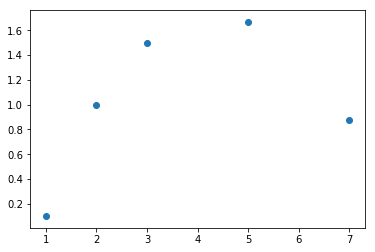

In [23]:
a = np.array([1.,2.,3.,4.,5.,np.nan,7.,8.])
b = np.array([9.98,2.,2.,np.nan,3.,7.,8.,np.nan])

print np.nanmean((9.87, 9.786))

plt.figure()
plt.scatter(a,a/b)
plt.show()